基于130个ABO3钙钛矿(具有稳定性)数据对phonon cutoff frequency进行ML建模与预测
</br>主要利用AuotML进行机器学习建模与超参数优化

更新：
</br><1>数据集扩充➡345条,包含具有稳定性与非稳定性的钙钛矿



In [2]:
# 导入基础所用的pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
import random
import pickle

#AutoML
from flaml import AutoML
# kflod
from sklearn.model_selection import KFold

In [3]:
# UtilTools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 对预测结果进行评估
def regression_metrics(true,pred):
    print('回归模型评估指标结果:》》》》》》》》》》》》')
    #预测值与真实值的绝对平方误差的平均值（方差误差-mse）
    print('均方误差【MSE】:', mean_squared_error(true, pred))
    print('均方根误差【RMSE】:',np.sqrt(mean_squared_error(true,pred)))
    #预测值与真实值的绝对误差的平均值     
    print('平均绝对误差【MAE】:',mean_absolute_error(true,pred))
    print('预测精度R方得分【R2】: ',r2_score(true, pred))
    
    result_dict = {
    'model_name': automl.best_estimator,
    'r2': r2_score(true, pred),
    'mae': mean_absolute_error(true,pred),
    'rmse':np.sqrt(mean_squared_error(true,pred))
    }
    return result_dict

In [4]:
#Performng standard scaling--标准化处理
from sklearn.preprocessing import StandardScaler

def dataStandardScaler(X):
    std_scale = StandardScaler().fit(X) # 标准化、归一化的结果
    X_std = std_scale.transform(X)     # 格式转化-》 numpy
    # 格式转化-》pandas
    X_std = pd.DataFrame(X_std,
                         columns=X.columns,
                         index=X.index)
    return X_std

In [5]:
# R2图
from sklearn.metrics import r2_score
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([10, xy_max], [10, xy_max], 'k--', label='ideal')  ## 对角线
    ##绘制拟合线
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit') ## 拟合线
    
    plt.axis('scaled') # x 、y 区间范围一致
    plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
    plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内
    plt.xlabel(f'Actual {label}') # x坐标轴名称
    plt.ylabel(f'Predicted {label}') # y坐标轴名称
    # plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}') # 图的标题
    plt.title(f'{model}, r2: {r2_score(act, pred):0.4f}') # 图的标题
    plt.legend(loc='upper left') # 图例 loc：位置
    
    return plot

In [6]:
# MAE RMSE MAE图


In [6]:
# 统计数据分布情况
def countResult(df_count,columnName):     
    df_condition = df_count
    columnName = columnName
    result_dict={}
    for j in range(0,130,10):
        condition = (df_condition[columnName] >= j) & (df_condition[columnName] < j+10)
        subset = df_condition[condition]
        count = len(subset)
        key = "["+str(j)+","+str(j+10)+"]"
        result_dict[key]=count
    return result_dict

In [7]:
# 设置 Pandas 显示选项
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

# 导入Phonon datasets

In [86]:
# 导入phonon数据
path = "train_data/phonon1/trainData(2).csv"
df_phonon_train = pd.read_csv(path)
df_phonon_train.dropna(axis=1,how='all',inplace=True)
df_phonon_train

number material_id formula   Wmax  nsites      volume   density  spg_num  \
0         1   mp-775761  AgClO3  25.79      20  291.059723  4.366023      198   
1         2   mp-849271   AgIO3  21.92      20  331.979908  5.657596       62   
2         3     mp-8196   AgNO3  42.39       5   66.943057  4.213744      160   
3         4   mp-558637  AgTeO3  20.54      40  574.826171  6.550948       14   
4         5   mp-561489  AgTeO3  21.80      20  274.180033  6.867123       11   
..      ...         ...     ...    ...     ...         ...       ...      ...   
340     341    mp-13334  ZnSnO3  20.30      10  117.570079  6.556765      161   
341     342    mp-16819  ZnTeO3  23.07      40  572.633639  5.591035       61   
342     343   mp-647557  ZrPbO3  23.09      40  605.836514  7.596077       32   
343     344   mp-755798  ZrPbO3  22.85      20  291.636419  7.889928       62   
344     345    mp-20337  ZrPbO3  23.46       5   76.358380  7.533523       38   

             a         b  ...  AtomM_mean   AtomM_std  Ra_min  Ra_max  \
0     6.627159  6.627159  ...   38.263880   47.583699     0.6    1.60   
1     5.915064  6.645817  ...   56.554174   66.859027     0.6    1.60   
2     4.151836  4.151836  ...   33.974620   49.382995     0.6    1.60   
3    11.826693  6.024564  ...   56.693280   67.120922     0.6    1.60   
4     5.461746  6.918137  ...   56.693280   67.120922     0.6    1.60   
..         ...       ...  ...         ...         ...     ...     ...   
340   5.659122  5.659122  ...   46.423440   54.650398     0.6    1.45   
341   6.329067  7.339284  ...   48.201440   58.891988     0.6    1.40   
342   6.042341  8.386099  ...   69.284440  100.035587     0.6    1.80   
343   5.889325  5.927420  ...   69.284440  100.035587     0.6    1.80   
344   4.276791  4.276791  ...   69.284440  100.035587     0.6    1.80   

     Ra_mean    Ra_std   TC_min  TC_max    TC_mean      TC_std  
0       0.88  0.523723  0.00890   430.0  86.017728  229.832823  
1       0.96  0.595219  0.02658   430.0  86.105748  229.774116  
2       0.81  0.528475  0.02583   430.0  86.021114  229.830561  
3       0.96  0.595219  0.02658   430.0  86.615948  229.438281  
4       0.96  0.595219  0.02658   430.0  86.615948  229.438281  
..       ...       ...      ...     ...        ...         ...  
340     0.92  0.525425  0.02658   120.0  37.415948   65.162534  
341     0.91  0.507796  0.02658   120.0  24.615948   63.749727  
342     1.03  0.711638  0.02658    35.0  11.615948   19.633707  
343     1.03  0.711638  0.02658    35.0  11.615948   19.633707  
344     1.03  0.711638  0.02658    35.0  11.615948   19.633707  

[345 rows x 104 columns]

In [87]:
# 设置 Pandas 显示选项
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_phonon_train.isnull().sum()

number         0
material_id    0
formula        0
Wmax           0
nsites         0
volume         0
density        0
spg_num        0
a              0
b              0
c              0
alpha          0
beta           0
gamma          0
Ef             0
Eg             0
Num_min        0
Num_max        0
Num_mean       0
Num_std        0
MenNum_min     0
MenNum_max     0
MenNum_mean    0
MenNum_std     0
Tm_min         0
Tm_max         0
Tm_mean        0
Tm_std         0
Column_min     0
Column_max     0
Column_mean    0
Column_std     0
Row_min        0
Row_max        0
Row_mean       0
Row_std        0
Rc_min         0
Rc_max         0
Rc_mean        0
Rc_std         0
EG_min         0
EG_max         0
EG_mean        0
EG_std         0
NsV_min        0
NsV_max        0
NsV_mean       0
NsV_std        0
NpV_min        0
NpV_max        0
NpV_mean       0
NpV_std        0
NdV_min        0
NdV_max        0
NdV_mean       0
NdV_std        0
NfV_min        0
NfV_max        0
NfV_mean      

In [88]:
# 目标列
target_phonon = df_phonon_train.loc[:,'Wmax'] 
target_phonon 

0       25.79
1       21.92
2       42.39
3       20.54
4       21.80
5       41.02
6       24.94
7       24.31
8       22.78
9       21.91
10      21.00
11      45.14
12      45.07
13      44.66
14      45.47
15      23.89
16      16.44
17      23.75
18      32.75
19      31.19
20      31.26
21      19.06
22      22.24
23      23.08
24      23.17
25      23.76
26      23.52
27      22.84
28      24.17
29      23.15
30      24.50
31      39.19
32      17.50
33      45.47
34      46.10
35      47.18
36      45.61
37      23.70
38      26.39
39      23.74
40      18.16
41      19.94
42      24.69
43      23.58
44      33.15
45      34.65
46      34.25
47      19.28
48      21.13
49      23.66
50      23.60
51      23.95
52      25.12
53      22.88
54      25.05
55      23.91
56      16.77
57      44.64
58      25.02
59      23.96
60      20.49
61      24.20
62      23.02
63      33.25
64      31.92
65      18.79
66      20.78
67      21.49
68      23.95
69      28.48
70      28.76
71    

In [89]:
# 特征列
featureset_phonon = df_phonon_train.iloc[:,4:]
featureset_phonon.head()

nsites      volume   density  spg_num          a         b         c  \
0      20  291.059723  4.366023      198   6.627159  6.627159  6.627159   
1      20  331.979908  5.657596       62   5.915064  6.645817  8.445084   
2       5   66.943057  4.213744      160   4.151836  4.151836  4.151836   
3      40  574.826171  6.550948       14  11.826693  6.024564  9.221229   
4      20  274.180033  6.867123       11   5.461746  6.918137  7.399802   

       alpha       beta       gamma        Ef      Eg  Num_min  Num_max  \
0  90.000000  90.000000   90.000000 -0.416786  2.9250        8       47   
1  90.000000  90.000000   90.000000 -0.698568  1.9765        8       53   
2  77.224160  77.224158   77.224160 -0.652688  1.7204        7       47   
3  61.033231  90.000000   90.000000 -1.128791  1.6662        8       52   
4  90.000001  89.999993  101.302165 -1.129141  1.1676        8       52   

   Num_mean    Num_std  MenNum_min  MenNum_max  MenNum_mean  MenNum_std  \
0      17.6  20.188398          65          94         84.0   13.201731   
1      24.8  27.612109          65          96         84.4   13.773681   
2      15.6  20.986390          65          87         81.6   11.389218   
3      24.6  27.250164          65          90         83.2   12.259107   
4      24.6  27.250164          65          90         83.2   12.259107   

   Tm_min   Tm_max  Tm_mean      Tm_std  Column_min  Column_max  Column_mean  \
0    54.8  1234.93  314.186  618.160743          11          17         15.2   
1    54.8  1234.93  357.236  611.095722          11          17         15.2   
2    54.8  1234.93  292.476  629.718042          11          16         14.8   
3    54.8  1234.93  424.398  642.464671          11          16         15.0   
4    54.8  1234.93  424.398  642.464671          11          16         15.0   

   Column_std  Row_min  Row_max  Row_mean   Row_std  Rc_min  Rc_max  Rc_mean  \
0    2.853569        2        5       2.8  1.558387      66     145     89.0   
1    2.853569        2        5       3.2  1.963961      66     145     96.4   
2    2.591194        2        5       2.6  1.603567      66     145     82.8   
3    2.672612        2        5       3.2  1.963961      66     145     96.2   
4    2.672612        2        5       3.2  1.963961      66     145     96.2   

      Rc_std  EG_min  EG_max  EG_mean    EG_std  NsV_min  NsV_max  NsV_mean  \
0  41.798838    1.93    3.44    3.082  0.783235        1        2       1.8   
1  49.818241    1.93    3.44    2.982  0.810573        1        2       1.8   
2  41.639610    1.93    3.44    3.058  0.781592        1        2       1.8   
3  49.514789    1.93    3.44    2.870  0.935643        1        2       1.8   
4  49.514789    1.93    3.44    2.870  0.935643        1        2       1.8   

    NsV_std  NpV_min  NpV_max  NpV_mean   NpV_std  NdV_min  NdV_max  NdV_mean  \
0  0.534522        0        5       3.4  2.329929        0       10       2.0   
1  0.534522        0        5       3.4  2.329929        0       10       4.0   
2  0.534522        0        4       3.0  2.070197        0       10       2.0   
3  0.534522        0        4       3.2  2.138090        0       10       4.0   
4  0.534522        0        4       3.2  2.138090        0       10       4.0   

    NdV_std  NfV_min  NfV_max  NfV_mean  NfV_std  NV_min  NV_max  NV_mean  \
0  5.345225        0        0       0.0      0.0       6      11      7.2   
1  6.546537        0        0       0.0      0.0       6      17      9.2   
2  5.345225        0        0       0.0      0.0       5      11      6.8   
3  6.546537        0        0       0.0      0.0       6      16      9.0   
4  6.546537        0        0       0.0      0.0       6      16      9.0   

     NV_std  NsU_min  NsU_max  NsU_mean   NsU_std  NpU_min  NpU_max  NpU_mean  \
0  2.591194        0        1       0.2  0.534522        0        2       1.4   
1  5.818689        0        1       0.2  0.534522        0        2       1.4   
2  2.853569        0

In [90]:
# 统计数据分布情况
def countResult(df_count,columnName):     
    df_condition = df_count
    columnName = columnName
    result_dict={}
    for j in range(0,130,10):
        condition = (df_condition[columnName] >= j) & (df_condition[columnName] < j+10)
        subset = df_condition[condition]
        count = len(subset)
        key = "["+str(j)+","+str(j+10)+"]"
        result_dict[key]=count
    return result_dict

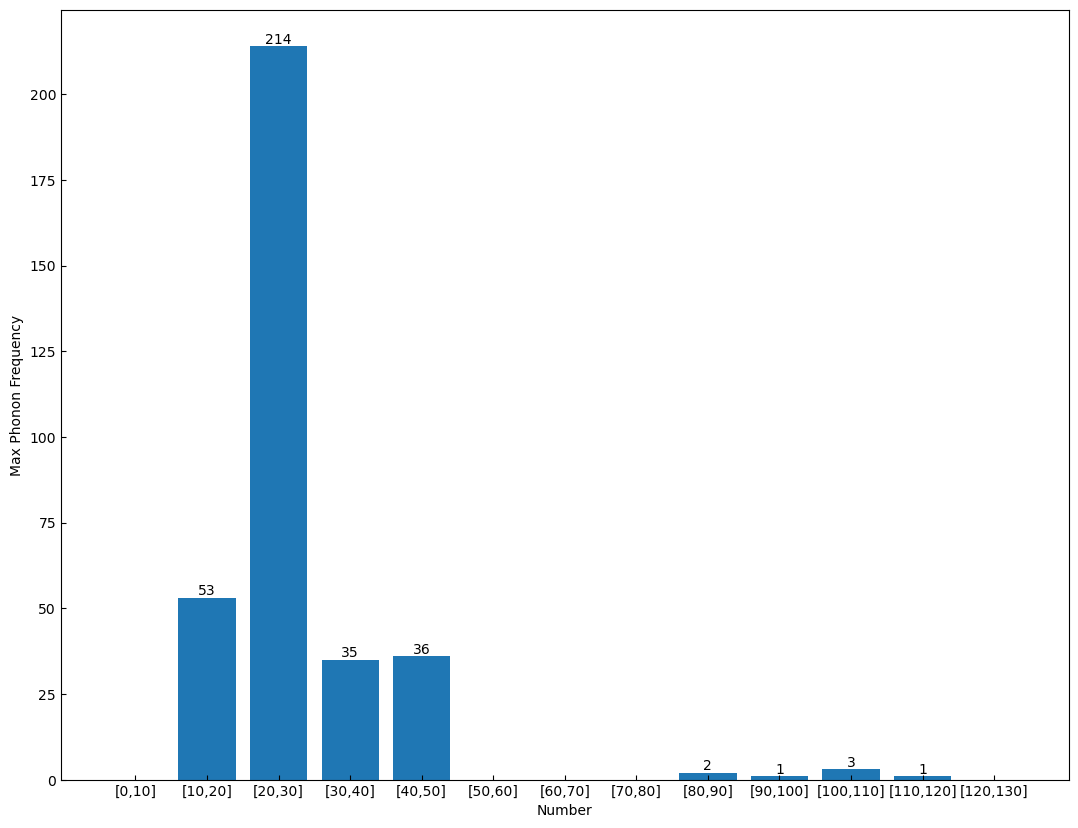

In [35]:
# 绘制 Wmax 分布情况

phononDict = countResult(df_phonon_train,'Wmax')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

In [91]:
# 计算特征集合的方差
# 计算特征方差
variance = featureset_phonon.var()
pd.set_option('display.float_format', '{:.4f}'.format)
print(variance)

nsites           230.8422
volume         47209.6923
density            3.4095
spg_num         4735.4389
a                  2.9120
b                  2.2825
c                 10.9550
alpha            246.4300
beta             241.6961
gamma            343.9929
Ef                 0.7230
Eg                 1.6649
Num_min            2.4444
Num_max          378.7063
Num_mean          39.8771
Num_std          112.5792
MenNum_min       716.2039
MenNum_max         4.9342
MenNum_mean       57.1019
MenNum_std       203.3351
Tm_min            33.1699
Tm_max        816951.9820
Tm_mean        53937.0578
Tm_std        220737.4273
Column_min        14.9678
Column_max         0.0674
Column_mean        1.7608
Column_std         4.7625
Row_min            0.0199
Row_max            0.7262
Row_mean           0.1160
Row_std            0.2352
Rc_min            24.4216
Rc_max           770.9403
Rc_mean           85.5134
Rc_std           200.9025
EG_min             0.1300
EG_max             0.0000
EG_mean     

In [92]:
# 输出删除的特征名
drop_features = variance[variance < 0.001]
print("方差小于0.0001的特征长度：", len(drop_features.index))
print("方差小于0.0001的特征：", drop_features.index)

# 保留方差大于0.01的特征
Variance_Selected_features = variance[variance >= 0.001]
print("方差大于0.0001的特征长度：", len(Variance_Selected_features.index))
print("方差大于0.0001的特征：", Variance_Selected_features.index)

方差小于0.0001的特征长度： 8
方差小于0.0001的特征： Index(['EG_max', 'NsV_max', 'NdV_min', 'NfV_min', 'NsU_min', 'NdU_min',
       'NfU_min', 'TC_min'],
      dtype='object')
方差大于0.0001的特征长度： 92
方差大于0.0001的特征： Index(['nsites', 'volume', 'density', 'spg_num', 'a', 'b', 'c', 'alpha',
       'beta', 'gamma', 'Ef', 'Eg', 'Num_min', 'Num_max', 'Num_mean',
       'Num_std', 'MenNum_min', 'MenNum_max', 'MenNum_mean', 'MenNum_std',
       'Tm_min', 'Tm_max', 'Tm_mean', 'Tm_std', 'Column_min', 'Column_max',
       'Column_mean', 'Column_std', 'Row_min', 'Row_max', 'Row_mean',
       'Row_std', 'Rc_min', 'Rc_max', 'Rc_mean', 'Rc_std', 'EG_min', 'EG_mean',
       'EG_std', 'NsV_min', 'NsV_mean', 'NsV_std', 'NpV_min', 'NpV_max',
       'NpV_mean', 'NpV_std', 'NdV_max', 'NdV_mean', 'NdV_std', 'NfV_max',
       'NfV_mean', 'NfV_std', 'NV_min', 'NV_max', 'NV_mean', 'NV_std',
       'NsU_max', 'NsU_mean', 'NsU_std', 'NpU_min', 'NpU_max', 'NpU_mean',
       'NpU_std', 'NdU_max', 'NdU_mean', 'NdU_std', 'NfU_max', 'NfU_me

# 特征筛选

In [11]:
df_phonon_train.head()

number material_id formula    Wmax  nsites   volume  density  spg_num  \
0       1   mp-775761  AgClO3 25.7900      20 291.0597   4.3660      198   
1       2   mp-849271   AgIO3 21.9200      20 331.9799   5.6576       62   
2       3     mp-8196   AgNO3 42.3900       5  66.9431   4.2137      160   
3       4   mp-558637  AgTeO3 20.5400      40 574.8262   6.5509       14   
4       5   mp-561489  AgTeO3 21.8000      20 274.1800   6.8671       11   

        a      b  ...  AtomM_mean  AtomM_std  Ra_min  Ra_max  Ra_mean  Ra_std  \
0  6.6272 6.6272  ...     38.2639    47.5837  0.6000  1.6000   0.8800  0.5237   
1  5.9151 6.6458  ...     56.5542    66.8590  0.6000  1.6000   0.9600  0.5952   
2  4.1518 4.1518  ...     33.9746    49.3830  0.6000  1.6000   0.8100  0.5285   
3 11.8267 6.0246  ...     56.6933    67.1209  0.6000  1.6000   0.9600  0.5952   
4  5.4617 6.9181  ...     56.6933    67.1209  0.6000  1.6000   0.9600  0.5952   

   TC_min   TC_max  TC_mean   TC_std  
0  0.0089 430.0000  86.0177 229.8328  
1  0.0266 430.0000  86.1057 229.7741  
2  0.0258 430.0000  86.0211 229.8306  
3  0.0266 430.0000  86.6159 229.4383  
4  0.0266 430.0000  86.6159 229.4383  

[5 rows x 104 columns]

In [12]:
# split 特征集合
df_features_phonon = df_phonon_train.iloc[:,3:]

In [ ]:
# split 特征集合
df_features_phonon = df_phonon_train.iloc[:,3:]

In [13]:
# 复制源数据集
df_features = df_phonon_train.copy()
# 经过方差筛选后特征集合
varianceFeatureSet = ['Wmax'] + Variance_Selected_features.index.to_list()
df_features_varianced = df_features.loc[:,varianceFeatureSet]
df_features_varianced

Wmax  nsites   volume  density  spg_num       a      b       c   alpha  \
0   25.7900      20 291.0597   4.3660      198  6.6272 6.6272  6.6272 90.0000   
1   21.9200      20 331.9799   5.6576       62  5.9151 6.6458  8.4451 90.0000   
2   42.3900       5  66.9431   4.2137      160  4.1518 4.1518  4.1518 77.2242   
3   20.5400      40 574.8262   6.5509       14 11.8267 6.0246  9.2212 61.0332   
4   21.8000      20 274.1800   6.8671       11  5.4617 6.9181  7.3998 90.0000   
..      ...     ...      ...      ...      ...     ...    ...     ...     ...   
340 20.3000      10 117.5701   6.5568      161  5.6591 5.6591  5.6591 56.4281   
341 23.0700      40 572.6336   5.5910       61  6.3291 7.3393 12.3277 90.0000   
342 23.0900      40 605.8365   7.5961       32  6.0423 8.3861 11.9561 90.0000   
343 22.8500      20 291.6364   7.8899       62  5.8893 5.9274  8.3543 90.0000   
344 23.4600       5  76.3584   7.5335       38  4.2768 4.2768  4.1764 90.0000   

       beta  ...  AtomM_max  AtomM_mean  AtomM_std  Ra_min  Ra_max  Ra_mean  \
0   90.0000  ...   107.8682     38.2639    47.5837  0.6000  1.6000   0.8800   
1   90.0000  ...   126.9045     56.5542    66.8590  0.6000  1.6000   0.9600   
2   77.2242  ...   107.8682     33.9746    49.3830  0.6000  1.6000   0.8100   
3   90.0000  ...   127.6000     56.6933    67.1209  0.6000  1.6000   0.9600   
4   90.0000  ...   127.6000     56.6933    67.1209  0.6000  1.6000   0.9600   
..      ...  ...        ...         ...        ...     ...     ...      ...   
340 56.4281  ...   118.7100     46.4234    54.6504  0.6000  1.4500   0.9200   
341 90.0000  ...   127.6000     48.2014    58.8920  0.6000  1.4000   0.9100   
342 90.0000  ...   207.2000     69.2844   100.0356  0.6000  1.8000   1.0300   
343 90.0000  ...   207.2000     69.2844   100.0356  0.6000  1.8000   1.0300   
344 90.0000  ...   207.2000     69.2844   100.0356  0.6000  1.8000   1.0300   

     Ra_std   TC_max  TC_mean   TC_std  
0    0.5237 430.0000  86.0177 229.8328  
1    0.5952 430.0000  86.1057 229.7741  
2    0.5285 430.0000  86.0211 229.8306  
3    0.5952 430.0000  86.6159 229.4383  
4    0.5952 430.0000  86.6159 229.4383  
..      ...      ...      ...      ...  
340  0.5254 120.0000  37.4159  65.1625  
341  0.5078 120.0000  24.6159  63.7497  
342  0.7116  35.0000  11.6159  19.6337  
343  0.7116  35.0000  11.6159  19.6337  
344  0.7116  35.0000  11.6159  19.6337  

[345 rows x 93 columns]

## PCA

In [39]:
# 标准化处理
feature_pca_std=dataStandardScaler(df_features_phonon)
feature_pca_std

Wmax    nsites    volume   density   spg_num         a         b  \
0   -0.167278 -0.067824  0.010869 -0.725872  1.548473  0.462226  0.371960   
1   -0.470530 -0.067824  0.199474 -0.025377 -0.430724  0.044326  0.384328   
2    1.133491 -1.056523 -1.022104 -0.808461  0.995462 -0.990441 -1.268836   
3   -0.578666  1.250441  1.318773  0.459139 -1.129265  3.513622 -0.027477   
4   -0.479933 -0.067824 -0.066931  0.630620 -1.172923 -0.221708  0.564838   
5    1.026138 -0.726956 -0.955149 -1.197075  1.097333 -0.308158 -0.498194   
6   -0.233884  1.250441  0.509064 -0.481861 -0.852759 -0.491704  1.680659   
7   -0.283251  1.250441  0.488225 -0.451935 -0.852759 -0.495568  1.696270   
8   -0.403141 -0.726956 -0.813121 -0.049176  1.490261 -1.499844 -1.844210   
9   -0.471314 -0.067824  0.257859  0.307855 -0.430724  0.246600  0.120387   
10  -0.542621 -1.056523 -0.917832  0.178559  1.883190 -0.801263 -1.055158   
11   1.348979 -0.067824  0.092597 -0.791658 -0.430724 -0.281873  0.232232   
12   1.343494 -0.726956 -0.570400 -0.938907 -1.274794 -0.255654 -0.984932   
13   1.311367 -1.056523 -0.984586 -0.726815  0.995462 -0.893752 -1.159625   
14   1.374838 -0.726956 -0.558909 -0.970993 -1.158370 -0.714687 -0.957370   
15  -0.316162 -0.067824  0.262774 -0.405756 -1.056500 -0.702634 -0.208060   
16  -0.899940 -1.056523 -0.996477  1.425352  1.883190 -0.979756 -1.257398   
17  -0.327132 -0.726956 -0.515950 -0.400705 -1.172923 -0.652715 -0.253192   
18   0.378104  0.591309  1.059482 -0.870020 -1.114712  0.986114  0.963694   
19   0.255863 -0.067824  0.215536 -0.802084 -1.056500 -0.705118 -0.248137   
20   0.261348  1.250441  1.634515 -0.703768 -1.129265  0.328240  1.234811   
21  -0.694638 -1.056523 -1.002777  0.755357  1.883190 -0.995353 -1.274385   
22  -0.445455 -0.726956 -0.458317 -0.115727 -1.172923 -0.697831 -0.070867   
23  -0.379633  2.568706  3.891481 -0.108960 -0.430724  0.183654  4.180039   
24  -0.372580 -1.056523 -1.028130  0.105881  0.995462 -1.059708 -1.347074   
25  -0.326348  0.591309  0.526440  0.033572 -1.041947 -0.050849 -0.207561   
26  -0.345155  0.591309  0.514075  0.054534  1.490261 -0.055085 -0.212346   
27  -0.398439 -0.726956 -0.737282  0.168824  1.883190 -0.101600 -0.264885   
28  -0.294221 -1.056523 -1.029552  0.120994  0.107734 -1.085193 -1.375860   
29  -0.374148 -1.056523 -1.028418  0.108933 -0.779994 -1.089328 -1.331472   
30  -0.268362 -1.056523 -0.986142  0.238316  1.883190 -0.954906 -1.228699   
31   0.882740 -0.067824 -0.135322  0.625954 -1.129265 -0.471552  0.344018   
32  -0.816879 -0.067824  0.001547  0.608557 -1.129265 -0.047666 -0.026827   
33   1.374838 -0.726956 -0.763965 -1.627543  1.097333  0.304530  0.193841   
34   1.424205 -0.067824 -0.183938 -1.644604 -0.430724 -0.825921  0.349414   
35   1.508833 -0.067824 -0.251000 -1.554586 -0.430724 -0.483266 -0.168330   
36   1.385808 -0.397390 -0.447421 -1.682663 -1.260241 -0.468722 -0.679552   
37  -0.331050  3.886971  3.137632 -0.704969 -0.052348  2.910678  3.137484   
38  -0.120263  0.591309  0.690611 -1.113485 -1.114712  0.688980  0.628080   
39  -0.327915 -0.067824 -0.167818  0.712435 -0.430724 -0.171989 -0.228186   
40  -0.765162 -0.067824 -0.061894  0.770384 -0.430724 -0.094804 -0.091478   
41  -0.625682 -0.726956 -0.800871  1.343464 -0.416171 -1.578627 -0.576177   
42  -0.253474 -0.067824 -0.020604 -0.976756 -1.129265  0.325073  0.416575   
43  -0.340453 -0.067824  0.001252 -1.011496 -0.430724 -0.264786  0.240471   
44   0.409448  2.568706  2.344325 -1.519330 -1.129265  0.871991  0.674924   
45   0.526987  2.568706  2.445646 -1.561574 -1.114712  0.632389  0.564160   
46   0.495644  0.591309  0.559511 -1.563206 -1.114712  0.627892  0.559081   
47  -0.677399 -0.726956 -0.710572 -0.325253  0.820827  0.103468 -0.033259   
48  -0.532434 -0.067824 -0.183883 -0.099788 -0.430724 -0.185180 -0.245085   
49  -0.334184  2.568706  3.597444 -0.913829 -1.129265 -0.052547  1.728566   
50  -0.338886  0.591309  1.032019 -0.820290 -1.274794 -0.086824  1.588889   
51  -

Text(0, 0.5, 'Cumulative explained variance')

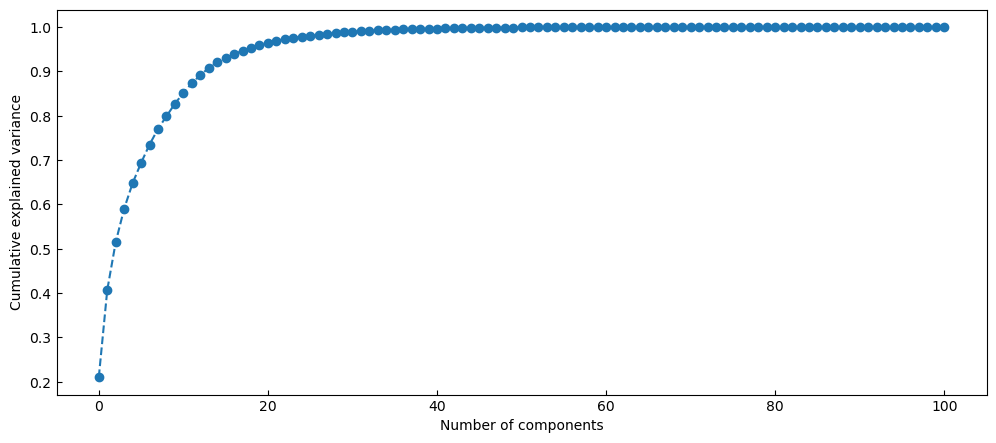

In [40]:
# import PCA module 
from sklearn.decomposition import PCA 
# scaling data 
# X_scaled = scaler.fit_transform(df_features_phonon) 
# fit PCA to data 
pca = PCA() 
pca.fit(feature_pca_std) 
evr = pca.explained_variance_ratio_ 
 
# visualizing the variance explained by each principal components 
plt.figure(figsize=(12, 5)) 
plt.plot(range(0, len(evr)), evr.cumsum(), marker="o", linestyle="--") 
plt.xlabel("Number of components") 
plt.ylabel("Cumulative explained variance")

## Pearson相关系数

<Axes: >

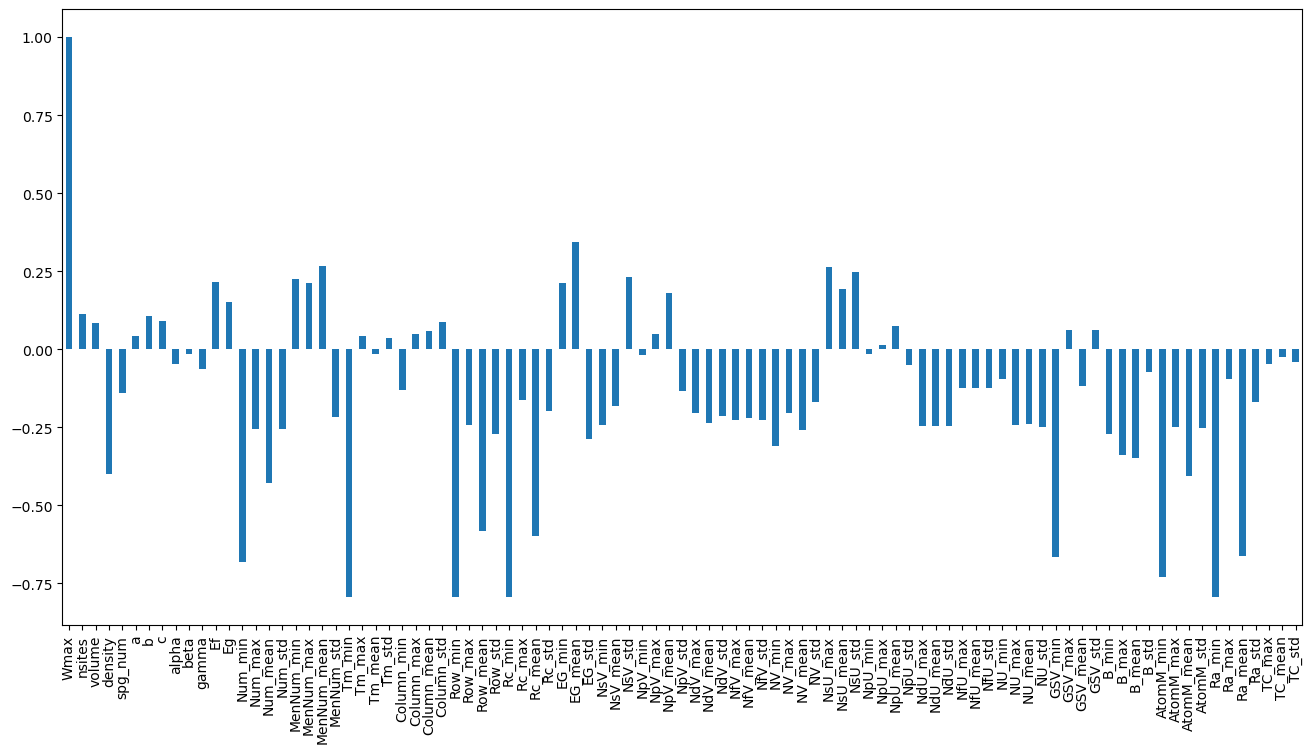

In [45]:
# correlation between target and features 

#x轴:[-1,1] , y轴：featureSet
# df_features_phonon.corr().loc['Wmax'].plot(kind='barh', figsize=(8,12))

#x轴:featureSet , y轴：[-1,1]
# df_features_phonon.corr().loc[:, 'Wmax'].plot(kind='bar', figsize=(16, 8))

# 经过方差筛选后
df_features_varianced.corr().loc[:, 'Wmax'].plot(kind='bar', figsize=(16, 8))

In [47]:
# drop uncorrelated numeric features (threshold <0.2) 
corr = abs(df_features_varianced.corr().loc['Wmax']) 
corr = corr[corr<0.2] 
cols_to_drop = corr.index.to_list() 
df_features_phonon_select = df_features_varianced.drop(cols_to_drop, axis=1)
print("与Wmax相关系数小于0.2：",cols_to_drop)
print("去掉与Wmax Pearson相关系数小于0.2后的特征集合数量：", len(df_features_phonon_select.columns))

与Wmax相关系数小于0.2： ['nsites', 'volume', 'spg_num', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Eg', 'Tm_max', 'Tm_mean', 'Tm_std', 'Column_min', 'Column_max', 'Column_mean', 'Column_std', 'Rc_max', 'Rc_std', 'NsV_mean', 'NpV_min', 'NpV_max', 'NpV_mean', 'NpV_std', 'NV_std', 'NsU_mean', 'NpU_min', 'NpU_max', 'NpU_mean', 'NpU_std', 'NfU_max', 'NfU_mean', 'NfU_std', 'NU_min', 'GSV_max', 'GSV_mean', 'GSV_std', 'B_std', 'Ra_max', 'Ra_std', 'TC_max', 'TC_mean', 'TC_std']
去掉与Wmax Pearson相关系数小于0.2后的特征集合数量： 50


In [48]:
# 去掉 target 的featureSet 
featureset_phonon = df_features_phonon_select.drop(columns=['Wmax'])
# pearson特征集
phonon_correlation_matrix = featureset_phonon.corr()
print("特征数量：", len(phonon_correlation_matrix))

特征数量： 49


In [49]:
# pearson特征集
phonon_correlation_matrix = featureset_phonon.corr()
phonon_correlation_matrix.head()

density      Ef  Num_min  Num_max  Num_mean  Num_std  MenNum_min  \
density    1.0000 -0.2672   0.2594   0.8370    0.8726   0.8627      0.2525   
Ef        -0.2672  1.0000  -0.1747  -0.0598   -0.0517  -0.0520      0.3681   
Num_min    0.2594 -0.1747   1.0000   0.1521    0.3697   0.1392     -0.0648   
Num_max    0.8370 -0.0598   0.1521   1.0000    0.8774   0.9882      0.2104   
Num_mean   0.8726 -0.0517   0.3697   0.8774    1.0000   0.9189      0.2137   

          MenNum_max  MenNum_mean  MenNum_std  ...  GSV_min   B_min   B_max  \
density      -0.2485       0.1014     -0.2577  ...   0.1932  0.5999  0.5465   
Ef            0.6238       0.6101     -0.3708  ...  -0.0270 -0.1060 -0.4997   
Num_min      -0.1999      -0.1215      0.0594  ...   0.5488  0.2095  0.2245   
Num_max      -0.0602       0.1394     -0.2080  ...   0.0901  0.4594  0.3238   
Num_mean     -0.0583       0.1331     -0.2069  ...   0.2706  0.4802  0.3617   

          B_mean  AtomM_min  AtomM_max  AtomM_mean  AtomM_std  Ra_min  Ra_mean  
density   0.6323     0.2594     0.8343      0.8735     0.8574  0.0986   0.2972  
Ef       -0.3689    -0.1938    -0.0544     -0.0477    -0.0498 -0.2298  -0.3191  
Num_min   0.2546     0.9957     0.1518      0.3418     0.1436  0.5857   0.6213  
Num_max   0.4169     0.1487     0.9994      0.8877     0.9892  0.0147   0.3166  
Num_mean  0.4672     0.3626     0.8784      0.9989     0.9162  0.1167   0.4853  

[5 rows x 49 columns]

In [50]:
# 筛选出pearson>0.8 的特征
phonon_correlated_features=set()
for i in range(len(phonon_correlation_matrix.columns)):
    for j in range(i):
        if abs(phonon_correlation_matrix.iloc[i,j]) > 0.8:
            colname = phonon_correlation_matrix.columns[i]
            phonon_correlated_features.add(colname)

print("筛选时需去掉的特征集合：", phonon_correlated_features)
print("筛选时需去掉的特征集合数量：", len(phonon_correlated_features))

筛选时需去掉的特征集合： {'NsU_std', 'Rc_min', 'EG_std', 'EG_mean', 'Num_mean', 'AtomM_mean', 'NdU_std', 'NdU_mean', 'EG_min', 'Row_min', 'AtomM_std', 'NfV_std', 'NV_mean', 'Num_std', 'Ra_mean', 'Ra_min', 'NfV_max', 'Row_std', 'NsV_std', 'NdV_std', 'B_mean', 'NU_mean', 'Row_max', 'AtomM_min', 'NdV_mean', 'NsU_max', 'NfV_mean', 'NU_std', 'MenNum_std', 'B_min', 'Num_max', 'AtomM_max', 'MenNum_mean', 'Row_mean'}
筛选时需去掉的特征集合数量： 34


In [51]:
# drop 高度相关的特征 ,筛选完的feature
phonon_featureSelected = featureset_phonon.drop(labels=phonon_correlated_features,axis=1)
phonon_featureSelected

density      Ef  Num_min  MenNum_min  MenNum_max  Tm_min  Rc_mean  \
0     4.3660 -0.4168        8          65          94 54.8000  89.0000   
1     5.6576 -0.6986        8          65          96 54.8000  96.4000   
2     4.2137 -0.6527        7          65          87 54.8000  82.8000   
3     6.5509 -1.1288        8          65          90 54.8000  96.2000   
4     6.8671 -1.1291        8          65          90 54.8000  96.2000   
..       ...     ...      ...         ...         ...     ...      ...   
340   6.5568 -1.9402        8          69          87 54.8000  91.8000   
341   5.5910 -1.6334        8          69          90 54.8000  91.6000   
342   7.5961 -2.8465        8          44          87 54.8000 103.8000   
343   7.8899 -2.8420        8          44          87 54.8000 103.8000   
344   7.5335 -2.8440        8          44          87 54.8000 103.8000   

     NsV_min  NdV_max  NV_min  NV_max  NdU_max  NU_max  GSV_min  B_max  
0          1       10       6      11        0       2   9.1050      3  
1          1       10       6      17        0       2   9.1050      3  
2          1       10       5      11        0       3   9.1050      3  
3          1       10       6      16        0       2   9.1050      3  
4          1       10       6      16        0       2   9.1050      3  
..       ...      ...     ...     ...      ...     ...      ...    ...  
340        2       10       6      14        0       4   9.1050      3  
341        2       10       6      16        0       2   9.1050      3  
342        2       10       4      28        8       8   9.1050      3  
343        2       10       4      28        8       8   9.1050      3  
344        2       10       4      28        8       8   9.1050      3  

[345 rows x 15 columns]

In [52]:
# 筛选完后的特征集合
print("pearson筛选完后剩余特征：",phonon_featureSelected.columns)
print("pearson筛选完后剩余特征数量：",len(phonon_featureSelected.columns))

pearson筛选完后剩余特征： Index(['density', 'Ef', 'Num_min', 'MenNum_min', 'MenNum_max', 'Tm_min',
       'Rc_mean', 'NsV_min', 'NdV_max', 'NV_min', 'NV_max', 'NdU_max',
       'NU_max', 'GSV_min', 'B_max'],
      dtype='object')
pearson筛选完后剩余特征数量： 15


In [53]:
# 两步筛选完后的特征集合
colName = ['number','material_id','formula','Wmax',]+phonon_featureSelected.columns.to_list()

df_save_phonon = df_phonon_train.loc[:,colName]
df_save_phonon

number material_id formula    Wmax  density      Ef  Num_min  MenNum_min  \
0         1   mp-775761  AgClO3 25.7900   4.3660 -0.4168        8          65   
1         2   mp-849271   AgIO3 21.9200   5.6576 -0.6986        8          65   
2         3     mp-8196   AgNO3 42.3900   4.2137 -0.6527        7          65   
3         4   mp-558637  AgTeO3 20.5400   6.5509 -1.1288        8          65   
4         5   mp-561489  AgTeO3 21.8000   6.8671 -1.1291        8          65   
..      ...         ...     ...     ...      ...     ...      ...         ...   
340     341    mp-13334  ZnSnO3 20.3000   6.5568 -1.9402        8          69   
341     342    mp-16819  ZnTeO3 23.0700   5.5910 -1.6334        8          69   
342     343   mp-647557  ZrPbO3 23.0900   7.5961 -2.8465        8          44   
343     344   mp-755798  ZrPbO3 22.8500   7.8899 -2.8420        8          44   
344     345    mp-20337  ZrPbO3 23.4600   7.5335 -2.8440        8          44   

     MenNum_max  Tm_min  Rc_mean  NsV_min  NdV_max  NV_min  NV_max  NdU_max  \
0            94 54.8000  89.0000        1       10       6      11        0   
1            96 54.8000  96.4000        1       10       6      17        0   
2            87 54.8000  82.8000        1       10       5      11        0   
3            90 54.8000  96.2000        1       10       6      16        0   
4            90 54.8000  96.2000        1       10       6      16        0   
..          ...     ...      ...      ...      ...     ...     ...      ...   
340          87 54.8000  91.8000        2       10       6      14        0   
341          90 54.8000  91.6000        2       10       6      16        0   
342          87 54.8000 103.8000        2       10       4      28        8   
343          87 54.8000 103.8000        2       10       4      28        8   
344          87 54.8000 103.8000        2       10       4      28        8   

     NU_max  GSV_min  B_max  
0         2   9.1050      3  
1         2   9.1050      3  
2         3   9.1050      3  
3         2   9.1050      3  
4         2   9.1050      3  
..      ...      ...    ...  
340       4   9.1050      3  
341       2   9.1050      3  
342       8   9.1050      3  
343       8   9.1050      3  
344       8   9.1050      3  

[345 rows x 19 columns]

In [54]:
# # 两步筛选完后的特征集合， 进行保存
df_save_phonon.to_csv('train_data/phonon1/trainData(4-f15).csv')

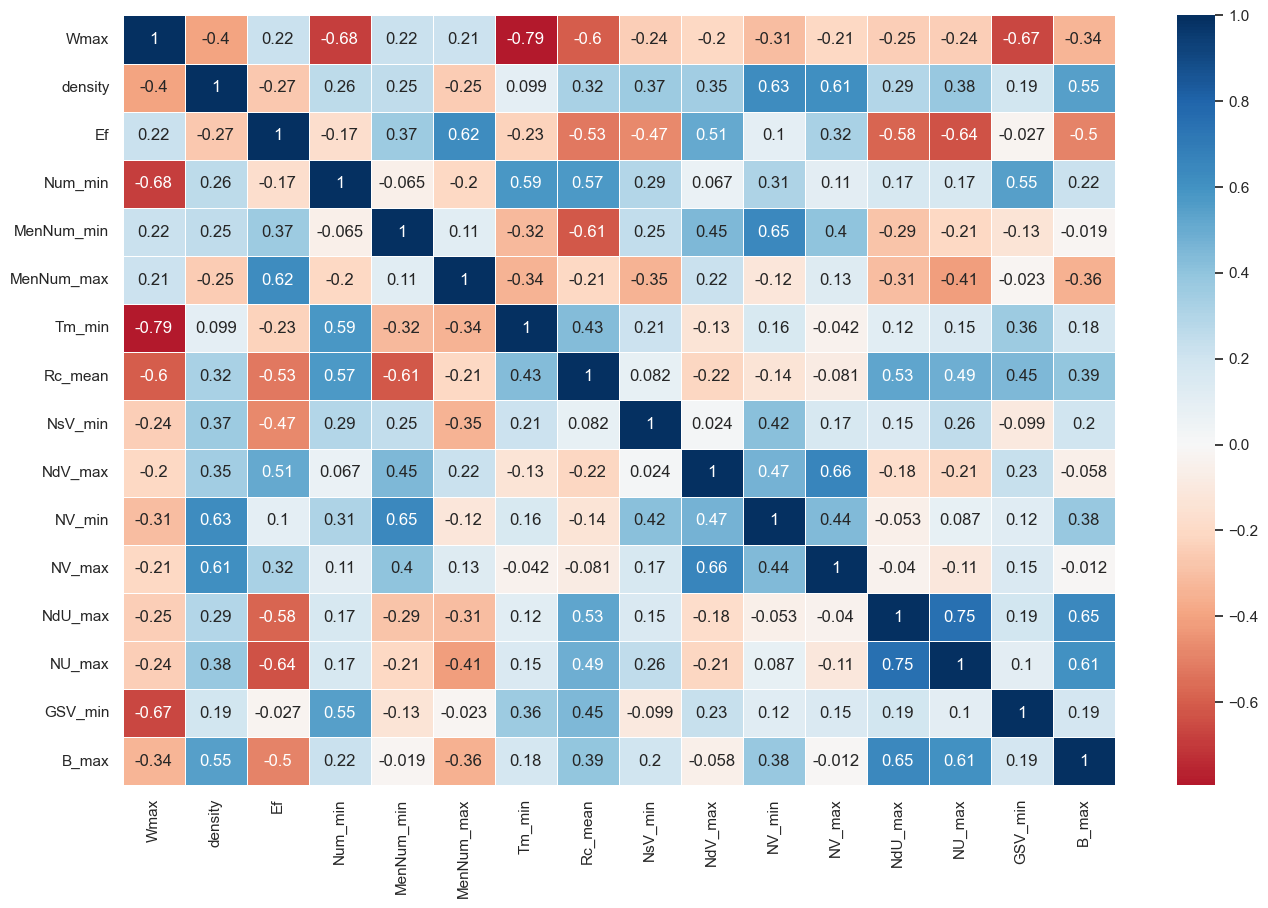

In [58]:
# 查看 target与 feature之间的 heatmap

df_corr = df_save_phonon.iloc[:,3:]
sns.set(rc={'figure.figsize':(16,10)}) 
sns.heatmap(df_corr.corr(), 
            annot=True, 
            linewidths=.5, 
            center=0, 
            cbar=True, 
            cmap="RdBu") 
plt.show()

## 递归特征筛选-RFE

In [14]:
df_features_varianced.head()

Wmax  nsites   volume  density  spg_num       a      b      c   alpha  \
0 25.7900      20 291.0597   4.3660      198  6.6272 6.6272 6.6272 90.0000   
1 21.9200      20 331.9799   5.6576       62  5.9151 6.6458 8.4451 90.0000   
2 42.3900       5  66.9431   4.2137      160  4.1518 4.1518 4.1518 77.2242   
3 20.5400      40 574.8262   6.5509       14 11.8267 6.0246 9.2212 61.0332   
4 21.8000      20 274.1800   6.8671       11  5.4617 6.9181 7.3998 90.0000   

     beta  ...  AtomM_max  AtomM_mean  AtomM_std  Ra_min  Ra_max  Ra_mean  \
0 90.0000  ...   107.8682     38.2639    47.5837  0.6000  1.6000   0.8800   
1 90.0000  ...   126.9045     56.5542    66.8590  0.6000  1.6000   0.9600   
2 77.2242  ...   107.8682     33.9746    49.3830  0.6000  1.6000   0.8100   
3 90.0000  ...   127.6000     56.6933    67.1209  0.6000  1.6000   0.9600   
4 90.0000  ...   127.6000     56.6933    67.1209  0.6000  1.6000   0.9600   

   Ra_std   TC_max  TC_mean   TC_std  
0  0.5237 430.0000  86.0177 229.8328  
1  0.5952 430.0000  86.1057 229.7741  
2  0.5285 430.0000  86.0211 229.8306  
3  0.5952 430.0000  86.6159 229.4383  
4  0.5952 430.0000  86.6159 229.4383  

[5 rows x 93 columns]

In [17]:
ref_feature = df_features_varianced.iloc[:,1:]
ref_feature_std = dataStandardScaler(ref_feature)
target = df_features_varianced['Wmax']
x_train,x_test,y_train,y_test = train_test_split(ref_feature_std,target,test_size=0.2,random_state=45)

In [18]:
x_train
# x_test
# y_train
# y_test

nsites  volume  density  spg_num       a       b       c   alpha    beta  \
332  0.5913  0.5248  -0.6527   1.3593  0.1963  0.0716  1.1763  0.4771  0.3446   
343 -0.0678  0.0135   1.1853  -0.4307  0.0292 -0.0919  0.0143  0.4771  0.3446   
102 -0.0678 -0.2908   1.4195  -0.4307 -0.3262 -0.3135 -0.2036  0.4771  0.3446   
245 -0.0678 -0.0300   0.7605  -1.1147 -0.0258 -0.1793  0.5554 -0.5569 -0.6995   
194 -0.7270 -0.7775  -1.8181   1.0973  0.1931  0.0680 -0.6470 -2.1823 -2.3408   
..      ...     ...      ...      ...     ...     ...     ...     ...     ...   
163 -0.7270 -0.7611  -0.5181  -1.1584 -0.2536 -0.4366 -0.9357  0.0077 -0.1294   
213 -1.0565 -0.9604   1.2433   1.8832 -0.8947 -1.1607 -1.2079  0.4771  0.3446   
95  -0.0678 -0.0884  -0.7426  -1.0565 -0.0722 -0.1164 -0.0916  0.4771  0.3446   
32  -0.0678  0.0015   0.6086  -1.1293 -0.0477 -0.0268  0.0071  0.4771  0.3515   
131 -1.0565 -1.0811   0.4643   1.8832 -1.2069 -1.5134 -1.3688  0.4771  0.3446   

      gamma  ...  AtomM_max  AtomM_mean  AtomM_std  Ra_min  Ra_max  Ra_mean  \
332  1.7877  ...    -0.8056     -0.6431    -0.8595  0.1439 -0.0769   0.7541   
343  0.1678  ...     1.4822      1.3816     1.3408  0.1439 -0.0769   0.6349   
102  0.1678  ...     0.6647      0.5970     0.5422  0.1439 -0.2639  -0.0805   
245 -1.3914  ...     1.5166      0.8343     1.3540  0.1439 -0.8247   0.2772   
194 -2.0831  ...    -2.0805     -1.8348    -2.0698  0.1439 -0.0769  -1.5113   
..      ...  ...        ...         ...        ...     ...     ...      ...   
163  1.9362  ...    -0.1702     -0.7066    -0.1566  0.1439 -1.3856  -0.4382   
213  0.1678  ...     1.9432      1.8796     1.8068  0.1439 -0.0769   0.7541   
95   0.1678  ...    -0.0707     -0.7163    -0.0199 -6.9488 -1.5725  -3.4190   
32   0.1678  ...     1.5166      0.7742     1.3647  0.1439 -0.0769   0.7541   
131  0.1678  ...     0.1614     -0.2490     0.0763  0.1439  0.4839   0.2772   

     Ra_std  TC_max  TC_mean  TC_std  
332  0.3294 -0.9433  -0.9116 -0.9195  
343  0.2256 -0.7392  -0.6655 -0.7301  
102 -0.3694 -0.8072  -0.7935 -0.8143  
245 -0.2152 -0.9547  -1.0001 -0.9678  
194 -0.3651  0.4517   0.1417  0.4521  
..      ...     ...      ...     ...  
163 -0.9747 -0.1721  -0.1637 -0.2080  
213  0.3294  3.7408   3.4578  3.6666  
95  -1.3510 -1.1310  -1.2301 -1.1460  
32   0.3294  1.1322   0.8106  1.1181  
131  0.2777  1.5292   1.2042  1.5067  

[276 rows x 92 columns]

In [76]:
ref_feature = df_phonon_train.iloc[:,4:]
ref_feature_std = dataStandardScaler(ref_feature)
target = df_phonon_train['Wmax']
x_train,x_test,y_train,y_test = train_test_split(ref_feature_std,target,test_size=0.2,random_state=45)

In [20]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost 

# 定义一个rf model
modelRF = RandomForestRegressor(
                        # n_estimators= 200,
                        random_state=45
                                )
# 定义一个xgb model
params = {'max_depth': 6, # 决策树的最大深度 
          'learning_rate': 0.1, # 学习率 
          'n_estimators': 100, # 弱分类器（决策树）的个数 
          'objective': 'reg:squarederror',# 损失函数，这里使用均方误差 
          'random_state': 42 # 随机种子 
         }
model_xgb = xgboost.XGBRegressor(**params)


rfe_train_dict = {}
rfe_pred_dict = {}
# for i in range(23, 92, 1):
# 打印过程
print("====================筛选至特征数为"+str(i)+"====================")

# 定义 RFE 对象
rfe = RFE(modelRF, n_features_to_select=22, verbose=1, step=1)

# 训练模型
rfe.fit(x_train, y_train)
# 训练结果
rfe_train_dict[str(i)] = rfe.score(x_train, y_train)

# 预测误差
pred_rfe = rfe.predict(x_test)
rfe_pred_dict[str(i)] = r2_score(y_test, pred_rfe)

====================筛选至特征数为10====================
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estima

In [21]:
rfe_train = pd.DataFrame(rfe_train_dict, index=[0])
rfe_pred = pd.DataFrame(rfe_pred_dict, index=[0])
rfe_train = rfe_train.transpose()
rfe_pred = rfe_pred.transpose()
rfe_train = rfe_train.rename(columns={0:'rfe_train'})
rfe_pred = rfe_pred.rename(columns={0:'rfe_pred'})
df_re = pd.concat([rfe_train, rfe_pred], axis=1)
df_re

rfe_train  rfe_pred
10     0.9950    0.9114

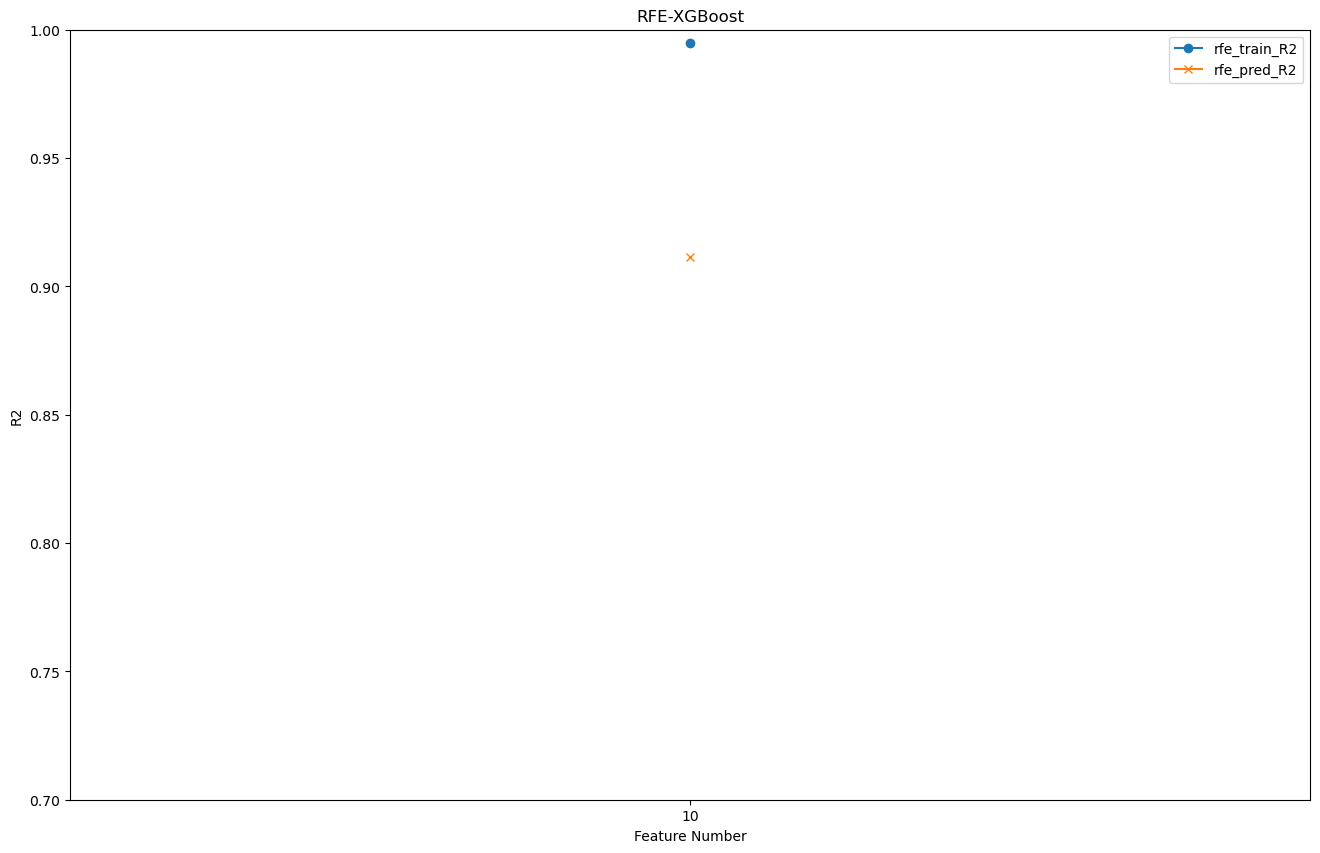

In [22]:
# 设置图片大小和内容
plot = plt.figure(figsize=(16,10))
plt.plot(df_re.index, df_re['rfe_train'], 'o-', label='rfe_train_R2')
plt.plot(df_re.index, df_re['rfe_pred'], 'x-', label='rfe_pred_R2')

# 设置坐标轴刻度
plt.xticks(range(len(df_re.index)), df_re.index)  # 设置x轴刻度为df的索引
plt.yticks(np.arange(0.7, 1, 0.05))
# 显示坐标轴刻度
plt.tick_params(axis='both', which='both', color='black')  # 设置刻度的可见性为0

# 设置背景
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内

# 显示坐标轴线条
ax = plt.gca()  # 获取当前的坐标轴对象
ax.spines['top'].set_visible(True)  # 显示顶部线条
ax.spines['right'].set_visible(True)  # 显示右侧线条
ax.spines['bottom'].set_visible(True)  # 显示底部线条
ax.spines['left'].set_visible(True)  # 显示左侧线条

# 添加图例、坐标轴标签和标题
plt.legend()
plt.xlabel('Feature Number')
plt.ylabel('R2')
plt.title('RFE-XGBoost')

# 显示图形
plt.show()

In [93]:
# 定义 RFE 对象
rfe = RFE(modelRF, n_features_to_select=30, verbose=1)

# 训练模型
rfe.fit(x_train, y_train)

# 获取被选择的特征的索引
selected_features_index = rfe.support_

# 获取被选择的特征的名称
selected_features_name = x_train.columns[selected_features_index]

# 选择特征
selected_features = rfe.transform(x_train)

# 将特征数据转换为 pandas 格式
selected_features_df = pd.DataFrame(selected_features, columns=selected_features_name)

NameError: name 'RFE' is not defined

In [26]:
"""
# RFR result

20 features = ['density', 'Num_min', 'MenNum_min', 'MenNum_mean', 'MenNum_std',
       'Tm_min', 'Tm_max', 'Tm_std', 'Row_min', 'Row_mean', 'Rc_min',
       'Rc_mean', 'EG_mean', 'NdV_max', 'NdV_mean', 'NdV_std', 'GSV_min',
       'AtomM_min', 'Ra_min', 'Ra_mean'],
       
21 features = ['density', 'Ef', 'Num_min', 'MenNum_min', 'MenNum_mean', 'MenNum_std',
       'Tm_min', 'Tm_max', 'Tm_std', 'Row_min', 'Row_mean', 'Rc_min',
       'Rc_mean', 'EG_mean', 'NdV_max', 'NdV_mean', 'NdV_std', 'GSV_min',
       'AtomM_min', 'Ra_min', 'Ra_mean']
       
22 features = ['density', 'Ef', 'Num_min', 'Num_mean', 'MenNum_min', 'MenNum_mean',
       'MenNum_std', 'Tm_min', 'Tm_max', 'Tm_std', 'Row_min', 'Row_mean',
       'Rc_min', 'Rc_mean', 'EG_mean', 'NdV_max', 'NdV_mean', 'NdV_std',
       'GSV_min', 'AtomM_min', 'Ra_min', 'Ra_mean']
"""

s =selected_features_df.columns
s

Index(['volume', 'density', 'b', 'Ef', 'Num_min', 'Num_std', 'MenNum_min',
       'MenNum_mean', 'MenNum_std', 'Tm_min', 'Tm_max', 'Tm_std', 'Column_std',
       'Row_mean', 'Rc_min', 'Rc_mean', 'EG_mean', 'NpV_std', 'NdV_max',
       'NdV_std', 'NV_max', 'NpU_max', 'NpU_mean', 'NU_min', 'GSV_min',
       'GSV_max', 'AtomM_min', 'Ra_min', 'Ra_mean', 'TC_std'],
      dtype='object')

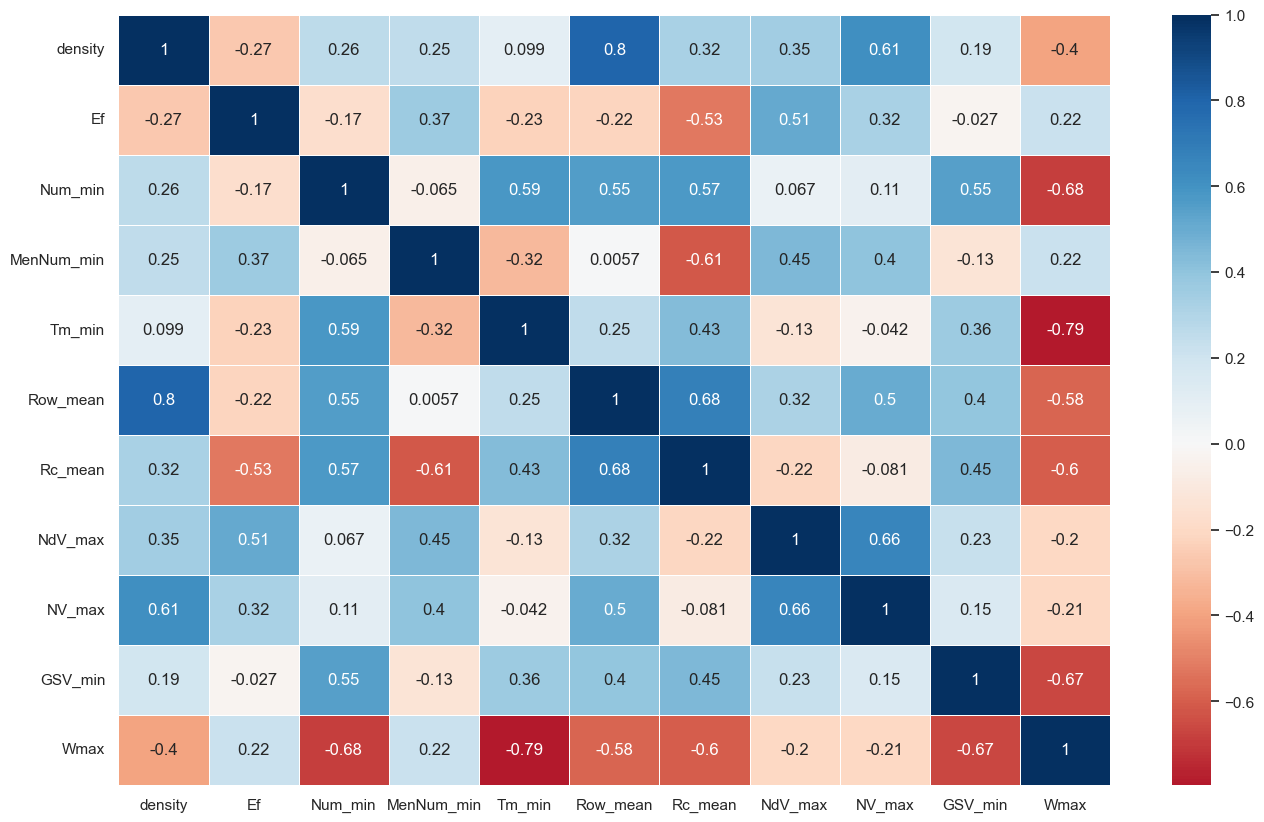

In [50]:
S = list(s)
# S.append('Wmax')
ref_selected_feature = df_features_varianced[S]

phonon_correlation_matrix = ref_selected_feature.corr()
# 筛选出pearson>0.8 的特征
phonon_correlated_features=set()
for i in range(len(phonon_correlation_matrix.columns)):
    for j in range(i):
        if abs(phonon_correlation_matrix.iloc[i,j]) > 0.8:
            colname = phonon_correlation_matrix.columns[i]
            phonon_correlated_features.add(colname)
            
# drop 高度相关的特征 ,筛选完的feature
phonon_featureSelected = ref_selected_feature.drop(labels=phonon_correlated_features,axis=1)  
SS = list(phonon_featureSelected.columns)
SS.append('Wmax')
df2 = df_features_varianced[SS]
# phonon_featureSelected
# drop uncorrelated numeric features (threshold <0.2) 
corr = abs(df2.corr().loc['Wmax']) 
corr = corr[corr<0.2] 
cols_to_drop = corr.index.to_list() 
df_features_phonon_select = df2.drop(cols_to_drop, axis=1)

# df_features_phonon_select

# # 查看 target与 feature之间的 heatmap
df_corr = df_features_phonon_select
sns.set(rc={'figure.figsize':(16,10)}) 
sns.heatmap(df_corr.corr(), 
            annot=True, 
            linewidths=.5, 
            center=0, 
            cbar=True, 
            cmap="RdBu") 
plt.show()

In [19]:
ref_selected_feature = df_phonon_train[s]
ref_feature_std = dataStandardScaler(ref_selected_feature)
target = df_phonon_train['Wmax']
x_train,x_test,y_train,y_test = train_test_split(ref_feature_std,target,test_size=0.2,random_state=45)

In [20]:
# 在使用Kflod 进行数据划分时，需要重新标序号
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_train

density         b        Ef   Num_min  MenNum_min  MenNum_std    Tm_max  \
0   -0.652730  0.071595 -1.534251  0.414032   -0.580726    1.187069  0.196441   
1    1.185346 -0.091870 -0.228471  0.414032    0.654157   -0.711196  0.544346   
2    1.419456 -0.313484 -0.581232  0.414032    0.242530   -0.321422  0.122206   
3    0.760514 -0.179300 -0.157147  0.414032   -0.580726    0.559578  0.196441   
4   -1.818105  0.068021  1.507371 -0.226511   -0.917512    0.864911 -1.402519   
..        ...       ...       ...       ...         ...         ...       ...   
271 -0.518081 -0.436596  0.671536 -2.788682   -0.954933    0.926180 -0.812065   
272  1.243314 -1.160700 -0.225154  0.414032   -0.318781    0.230033  0.230788   
273 -0.742554 -0.116412  2.048685 -4.069768    2.263248   -1.941251 -1.384814   
274  0.608557 -0.026827  0.439429  0.414032   -0.730409    0.709725 -0.578038   
275  0.464332 -1.513357 -1.258078  0.414032   -0.505885    0.410740 -0.491615   

      Tm_mean    Tm_std  Row_mean  ...   EG_mean   NpV_std   NdV_max  \
0    1.110151  0.629245  0.006817  ... -1.041795  1.183669 -1.084550   
1    0.347439  0.472171  1.182755  ...  0.674265 -0.385842  0.927115   
2   -0.237882  0.062258  0.594786  ... -0.310880  0.240752  0.927115   
3    0.028164  0.126389  0.594786  ...  0.229361 -0.607598  0.927115   
4   -1.631538 -1.457262 -2.345059  ...  1.166838 -0.607598 -1.308068   
..        ...       ...       ...  ...       ...       ...       ...   
271 -0.835053 -0.854732 -1.169121  ... -0.326770 -0.607598  0.927115   
272  0.650423  0.328896  1.770724  ...  0.308808  1.183669  0.927115   
273 -1.660049 -1.422615 -1.757090  ...  2.580999  0.240752  0.927115   
274 -0.574664 -0.617903  0.594786  ... -0.342659 -0.607598  0.927115   
275 -0.171856 -0.388671  0.006817  ... -0.835232  0.240752 -1.084550   

       NV_max   NpU_max    NU_max   GSV_min   GSV_max   GSV_std    TC_max  
0   -1.054603 -1.012043  0.991512  0.343891 -0.415654 -0.425076 -0.943324  
1    1.912200  0.638807  0.683894  0.343891 -0.626738 -0.582957 -0.739174  
2   -0.110620  1.464232 -0.238962  0.343891 -0.496598 -0.543951 -0.807224  
3    2.047055 -0.186618  0.991512  0.343891 -0.386633 -0.399372 -0.954666  
4   -1.054603 -0.186618 -0.854198  0.343891 -0.570515 -0.641390  0.451701  
..        ...       ...       ...       ...       ...       ...       ...  
271  0.159089 -0.186618 -0.854198  0.343891 -0.455589 -0.521390 -0.172091  
272 -0.380329 -1.012043  4.682932  0.343891 -0.772091 -0.829025  3.740785  
273  0.428799 -1.012043 -1.161817 -2.502426  0.112677  0.142189 -1.131040  
274  2.047055 -0.186618 -0.854198  0.343891 -0.147520  0.026220  1.132201  
275 -1.054603  1.464232  0.991512  0.343891 -0.190803 -0.257351  1.529160  

[276 rows x 22 columns]

## 读入feature engine后的数据集

In [8]:
"""
使用RFE以及去掉相关性大于0.8，小于0.2的，以及去掉方差为0的
"""
df_features_phonon_select
feature = df_features_phonon_select.iloc[:,:10]
target = df_features_phonon_select["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature)

# 数据划分
x_train, x_test, y_train, y_test = train_test_split(feature_std,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=45)

NameError: name 'df_features_phonon_select' is not defined

In [8]:
df_train_selected = pd.read_csv("train_data/phonon1/trainData(5-f10).csv")
corr_matrix = df_train_selected.iloc[:,3:]
corr_matrix.head()

Wmax   density        Ef  Num_min  MenNum_min  Tm_min  Row_mean  Rc_mean  \
0  25.79  4.366023 -0.416786        8          65    54.8       2.8     89.0   
1  21.92  5.657596 -0.698568        8          65    54.8       3.2     96.4   
2  42.39  4.213744 -0.652688        7          65    54.8       2.6     82.8   
3  20.54  6.550948 -1.128791        8          65    54.8       3.2     96.2   
4  21.80  6.867123 -1.129141        8          65    54.8       3.2     96.2   

   NdV_max  NV_max  GSV_min  
0       10      11    9.105  
1       10      17    9.105  
2       10      11    9.105  
3       10      16    9.105  
4       10      16    9.105

In [9]:
# 通过 pearson相关系数 特征筛选完后的dataset

df_train_selected = pd.read_csv("train_data/phonon1/trainData(4-f15).csv")
feature = df_train_selected.iloc[:,4:]
target = df_train_selected["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature)

# 数据划分
x_train, x_test, y_train, y_test = train_test_split(feature_std,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=45)

In [10]:
# 在使用Kflod 进行数据划分时，需要重新标序号
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_train

density        Ef   Num_min  MenNum_min  MenNum_max    Tm_min   Rc_mean  \
0   -0.652730 -1.534251  0.414032   -0.580726   -0.398569  0.143910  1.132559   
1    1.185346 -0.228471  0.414032    0.654157   -0.398569  0.143910  0.287848   
2    1.419456 -0.581232  0.414032    0.242530   -0.398569  0.143910  0.136234   
3    0.760514 -0.157147  0.414032   -0.580726   -0.398569  0.143910  0.222870   
4   -1.818105  1.507371 -0.226511   -0.917512   -0.398569  0.143910 -1.531528   
..        ...       ...       ...         ...         ...       ...       ...   
271 -0.518081  0.671536 -2.788682   -0.954933   -0.398569  0.143910 -0.881751   
272  1.243314 -0.225154  0.414032   -0.318781   -0.398569  0.143910  0.807670   
273 -0.742554  2.048685 -4.069768    2.263248    3.658990 -6.948792 -2.982698   
274  0.608557  0.439429  0.414032   -0.730409   -0.398569  0.143910  0.352826   
275  0.464332 -1.258078  0.414032   -0.505885   -0.398569  0.143910  0.439463   

      NsV_min   NdV_max    NV_min    NV_max   NdU_max    NU_max   GSV_min  \
0    0.644038 -1.084550 -0.017489 -1.054603  1.472685  0.991512  0.343891   
1    0.644038  0.927115  0.531033  1.912200  1.220162  0.683894  0.343891   
2    0.644038  0.927115  1.628078 -0.110620 -0.800022 -0.238962  0.343891   
3    0.644038  0.927115 -0.017489  2.047055  1.472685  0.991512  0.343891   
4   -1.472088 -1.308068 -1.114534 -1.054603 -0.800022 -0.854198  0.343891   
..        ...       ...       ...       ...       ...       ...       ...   
271 -1.472088  0.927115 -1.114534  0.159089 -0.800022 -0.854198  0.343891   
272 -1.472088  0.927115  1.079555 -0.380329  1.472685  4.682932  0.343891   
273 -1.472088  0.927115 -1.114534  0.428799 -0.800022 -1.161817 -2.502426   
274  0.644038  0.927115 -0.566011  2.047055 -0.800022 -0.854198  0.343891   
275  0.644038 -1.084550 -0.017489 -1.054603  1.472685  0.991512  0.343891   

        B_max  
0    0.806671  
1    0.806671  
2    0.806671  
3    0.806671  
4   -1.239663  
..        ...  
271 -1.239663  
272  0.806671  
273 -1.239663  
274 -1.239663  
275  0.806671  

[276 rows x 15 columns]

# ML建模

## 10 kflod cv automl model training

In [11]:
# 添加自定义的GBR model
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.data import CLASSIFICATION

class MyGradientBoostingRegressor(SKLearnEstimator):
    def __init__(self, task='binary',n_jobs=None, **config):
        '''Constructor
        Args:
            task: A string of the task type, one of
                'binary', 'multi', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''
        super().__init__(task,**config)
        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from sklearn.ensemble import GradientBoostingClassifier
            self.estimator_class = GradientBoostingClassifier
        else:
            from sklearn.ensemble import GradientBoostingRegressor
            self.estimator_class = GradientBoostingRegressor
    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space
        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {
            'loss':{'domain':tune.choice(['squared_error', 'absolute_error', 'huber', 'quantile'])},
            'max_depth': {'domain': tune.randint(lower=1, upper=50)},
            'n_estimators': {'domain': tune.randint(lower=1, upper=1000), 'low_cost_init_value': 4},
            'subsample':{'domain':tune.loguniform(lower=0.01, upper=1.0)},
            'max_features': {'domain': tune.loguniform(lower=0.1, upper=0.99)},
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0)},
            'min_samples_split': {'domain': tune.loguniform(lower=0.1, upper=1.0)},
        }
        return space
automl = AutoML()   
automl.add_learner("gbr", MyGradientBoostingRegressor)

In [47]:
# 填写Automl设置
settings = {
            "time_budget": 120,  # 总时间上限(单位秒)
            "metric": 'r2',  # 候选可以是: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
            # "estimator_list": ['xgboost','lgbm','catboost','rf','gbr'],
            # "estimator_list": ['xgboost'],
            # "estimator_list": ['lgbm'],
            # "estimator_list": ['catboost'],
            # "estimator_list": ['rf'],
            "estimator_list": ['gbr'],
            "task": 'regression',  # 任务类型
            "eval_method":'cv',
            "n_splits":10,
            # "log_file_name": 'log files/phonon_log_files/phonon_train_lgbm.log',  # flaml日志文件
            # "seed": 46,    # 随机种子
}

In [48]:
# 添加 10Kflod 
kFold=KFold(n_splits=10, random_state=56, shuffle=True)
automl.fit(X_train=x_train, y_train=y_train, **settings, split_type=kFold)

[flaml.automl.automl: 11-08 17:45:06] {2726} INFO - task = regression
[flaml.automl.automl: 11-08 17:45:06] {2728} INFO - Data split method: KFold(n_splits=10, random_state=56, shuffle=True)
[flaml.automl.automl: 11-08 17:45:06] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 11-08 17:45:06] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 11-08 17:45:06] {3004} INFO - List of ML learners in AutoML Run: ['gbr']
[flaml.automl.automl: 11-08 17:45:06] {3334} INFO - iteration 0, current learner gbr
[flaml.automl.automl: 11-08 17:45:06] {3472} INFO - Estimated sufficient time budget=1085s. Estimated necessary time budget=1s.
[flaml.automl.automl: 11-08 17:45:06] {3519} INFO -  at 0.1s,	estimator gbr's best error=1.1299,	best estimator gbr's best error=1.1299
[flaml.automl.automl: 11-08 17:45:06] {3334} INFO - iteration 1, current learner gbr
[flaml.automl.automl: 11-08 17:45:07] {3519} INFO -  at 0.7s,	estimator gbr's best error=1.1299,	best estimator gbr's best e

In [49]:
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: gbr
Best hyperparmeter config: {'n_estimators': 524, 'loss': 'huber', 'max_depth': 8, 'subsample': 1.0, 'max_features': 0.15175693935297419, 'learning_rate': 0.030707024664867077, 'min_samples_split': 0.2540484037860537}
Best accuracy on validation data: 0.9696
Training duration of best run: 1.704 s


In [85]:
## 模型存储与持久化

path_saveModel = 'model/phonon/6-26(Feature-22)/automl-'+automl.best_estimator+'.pkl'
store = path_saveModel
with open(store, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [142]:
## 模型加载
path_loadModel = 'model/phonon/6-26(Feature-22)/automl-xgboost.pkl'
store = path_loadModel
with open(store, 'rb') as f:
    automl = pickle.load(f)

回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 7.932075511874773
均方根误差【RMSE】: 2.8163940618945307
平均绝对误差【MAE】: 1.7298020216275916
预测精度R方得分【R2】:  0.9521079142800984


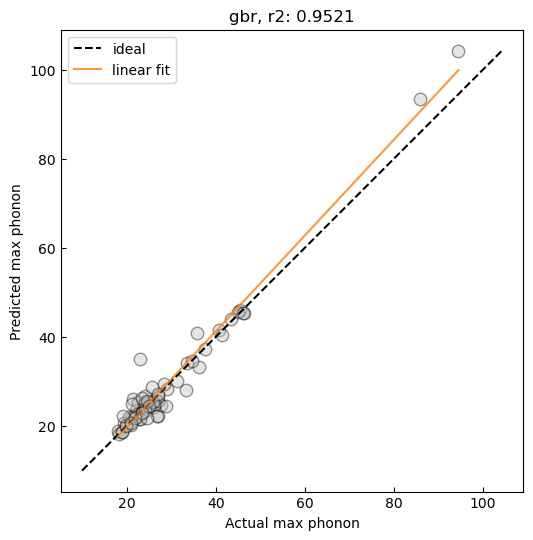

In [50]:
# predict metrics
ypred = automl.predict(x_test)
pred_result = regression_metrics(y_test,ypred)
plot=plot_pred_act(y_test,ypred,automl.best_estimator,reg_line=True,label='max phonon')

In [87]:
# 保存训练结果数据
# result\PIC\phonon_result_r2_pic
plot.savefig('result/PIC/phonon_result_r2_pic/6-26(PearsonF-22)/'+automl.best_estimator+'_result.png',bbox_inches='tight')

# 训练结果

In [16]:
# 记录10 kflod cv train result

df_train_result = pd.DataFrame(columns=['ML model','hyperparmeter','10KflodCV'])

In [51]:
# pd.concat(df_train_result,pd.DataFrame({'ML model':automl.best_estimator,
#                         'hyperparmeter':automl.best_config,
#                         '10KflodCV':1-automl.best_loss}))
df_train_result=df_train_result.append({'ML model':automl.best_estimator,
                                        'hyperparmeter':automl.best_config,
                                        '10KflodCV':1-automl.best_loss}, ignore_index=True)

C:\Users\94497\AppData\Local\Temp\ipykernel_15876\228668703.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_train_result=df_train_result.append({'ML model':automl.best_estimator,


In [52]:
df_train_result

ML model                                      hyperparmeter  10KflodCV
0      lgbm  {'n_estimators': 56, 'num_leaves': 59, 'min_ch...   0.945724
1   xgboost  {'n_estimators': 24, 'max_leaves': 21, 'min_ch...   0.939892
2  catboost  {'early_stopping_rounds': 15, 'learning_rate':...   0.918892
3        rf  {'n_estimators': 12, 'max_features': 0.6074030...   0.928772
4       gbr  {'n_estimators': 524, 'loss': 'huber', 'max_de...   0.969567

In [96]:
df_train_result.to_csv('model/phonon/6-26(Feature-22)/ML_train_result(3).csv')

In [97]:
df_train_result = pd.read_csv('model/phonon/6-26(Feature-22)/ML_train_result.csv')
df_train_result

ML model                                      hyperparmeter  10KflodCV
0   xgboost  {'n_estimators': 25, 'max_leaves': 6, 'min_chi...   0.923155
1      lgbm  {'n_estimators': 63, 'num_leaves': 25, 'min_ch...   0.933378
2  catboost  {'early_stopping_rounds': 10, 'learning_rate':...   0.917030
3        rf  {'n_estimators': 16, 'max_features': 0.3886703...   0.938159
4       gbr  {'n_estimators': 516, 'loss': 'huber', 'max_de...   0.936573

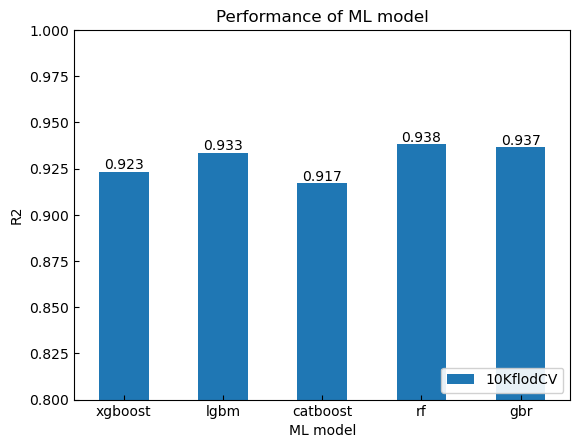

In [99]:
# 训练结果
'''
其中，ax.containers可以获取到每个柱子的容器，使用bar_label()方法在每个柱子上显示对应的数值。
label_type='edge'表示在柱子的边缘显示标签，
labels参数为一个列表，其中每个元素为对应柱子的数值，使用f-string将数值保留3位小数。
rot=0 x标签横向
'''
# 在柱状图上标识数据
ax = df_train_result.plot.bar(x='ML model', y=['10KflodCV'], rot=0)
plt.title(f'10KflodCV Performance of ML model')
plt.ylabel('R2')
plt.ylim(0.8,1.0)
# 在每个柱子上显示对应的数值
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f'{h:.3f}' for h in i.datavalues])

plt.legend(loc='lower right', framealpha=0.9)
plt.savefig('result/PIC/phonon_result_r2_pic/6-26(PearsonF-22)/phonon_train_R2.png',bbox_inches='tight')
plt.show()

# 预测结果

In [19]:
df_pred_result = pd.DataFrame(columns=['model_name','r2','mae','rmse'])

In [53]:
df_pred_result = df_pred_result.append(pred_result, ignore_index=True)

C:\Users\94497\AppData\Local\Temp\ipykernel_15876\2644397907.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_pred_result = df_pred_result.append(pred_result, ignore_index=True)


In [54]:
df_pred_result

model_name        r2       mae      rmse
0       lgbm  0.973322  1.339655  2.102043
1    xgboost  0.967292  1.631205  2.327497
2   catboost  0.966534  1.544911  2.354323
3         rf  0.925761  1.855133  3.506522
4        gbr  0.952108  1.729802  2.816394

In [100]:
df_pred_result.to_csv('result/6-26/phonon_pred_result(PearsonF-22).csv')

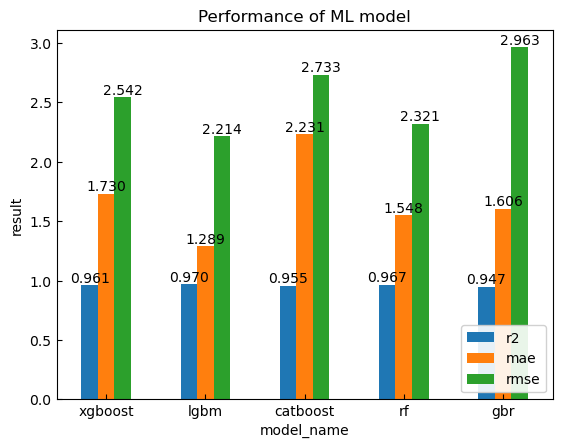

In [101]:
# 预测结果
'''
其中，ax.containers可以获取到每个柱子的容器，使用bar_label()方法在每个柱子上显示对应的数值。
label_type='edge'表示在柱子的边缘显示标签，
labels参数为一个列表，其中每个元素为对应柱子的数值，使用f-string将数值保留3位小数。
rot=0 x标签横向
'''
# 在柱状图上标识数据
ax = df_pred_result.plot.bar(x='model_name', y=['r2', 'mae', 'rmse'], rot=0)
plt.title(f'Performance of ML model')
plt.ylabel('result')
# 在每个柱子上显示对应的数值
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f'{h:.3f}' for h in i.datavalues])

plt.legend(loc='lower right', framealpha=0.9)
plt.savefig('result/PIC/phonon_result_pred_metrics_pic/6-26(PearsonF-22)/phonon_pred_metrics.png',bbox_inches='tight')
plt.show()

# 重复训练

In [48]:
feature

nsites      volume   density  spg_num          a         b          c  \
0        20  291.059723  4.366023      198   6.627159  6.627159   6.627159   
1        20  331.979908  5.657596       62   5.915064  6.645817   8.445084   
2         5   66.943057  4.213744      160   4.151836  4.151836   4.151836   
3        40  574.826171  6.550948       14  11.826693  6.024564   9.221229   
4        20  274.180033  6.867123       11   5.461746  6.918137   7.399802   
..      ...         ...       ...      ...        ...       ...        ...   
340      10  117.570079  6.556765      161   5.659122  5.659122   5.659122   
341      40  572.633639  5.591035       61   6.329067  7.339284  12.327740   
342      40  605.836514  7.596077       32   6.042341  8.386099  11.956119   
343      20  291.636419  7.889928       62   5.889325  5.927420   8.354309   
344       5   76.358380  7.533523       38   4.276791  4.276791   4.176356   

         alpha       beta       gamma  ...  AtomM_mean   AtomM_std  Ra_min  \
0    90.000000  90.000000   90.000000  ...   38.263880   47.583699     0.6   
1    90.000000  90.000000   90.000000  ...   56.554174   66.859027     0.6   
2    77.224160  77.224158   77.224160  ...   33.974620   49.382995     0.6   
3    61.033231  90.000000   90.000000  ...   56.693280   67.120922     0.6   
4    90.000001  89.999993  101.302165  ...   56.693280   67.120922     0.6   
..         ...        ...         ...  ...         ...         ...     ...   
340  56.428095  56.428095   56.428092  ...   46.423440   54.650398     0.6   
341  90.000000  90.000000   90.000000  ...   48.201440   58.891988     0.6   
342  90.000000  90.000000   90.000000  ...   69.284440  100.035587     0.6   
343  90.000000  90.000000   90.000000  ...   69.284440  100.035587     0.6   
344  90.000000  90.000000   91.634838  ...   69.284440  100.035587     0.6   

     Ra_max  Ra_mean    Ra_std   TC_min  TC_max    TC_mean      TC_std  
0      1.60     0.88  0.523723  0.00890   430.0  86.017728  229.832823  
1      1.60     0.96  0.595219  0.02658   430.0  86.105748  229.774116  
2      1.60     0.81  0.528475  0.02583   430.0  86.021114  229.830561  
3      1.60     0.96  0.595219  0.02658   430.0  86.615948  229.438281  
4      1.60     0.96  0.595219  0.02658   430.0  86.615948  229.438281  
..      ...      ...       ...      ...     ...        ...         ...  
340    1.45     0.92  0.525425  0.02658   120.0  37.415948   65.162534  
341    1.40     0.91  0.507796  0.02658   120.0  24.615948   63.749727  
342    1.80     1.03  0.711638  0.02658    35.0  11.615948   19.633707  
343    1.80     1.03  0.711638  0.02658    35.0  11.615948   19.633707  
344    1.80     1.03  0.711638  0.02658    35.0  11.615948   19.633707  

[345 rows x 100 columns]

In [22]:
import lightgbm as lgb
# 特征筛选完后的dataset
df_train_selected = pd.read_csv("train_data/phonon1/trainData(3-f22).csv")
feature = df_train_selected.iloc[:,4:]
target = df_train_selected["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature)

# 生成随机种子
random_state = []
for _ in range(10):
    random_state.append(random.randint(0, 50))

# 记录结果
df_result = pd.DataFrame(columns=['randomState',
                                  'r2_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])

# 进行重复训练    
for i in random_state:
    # 数据划分
    x_train, x_test, y_train, y_test = train_test_split(feature_std,
                                                        target,
                                                        test_size=0.2,
                                                        random_state=i)
    
    # load model
    # 定义LightGBM模型的参数
    # 精度更高
    # params = {'n_estimators': 56,
    #           'num_leaves': 59,
    #           'min_child_samples': 3,
    #           'learning_rate': 0.20965284786018218,
    #           'log_max_bin': 7,
    #           'colsample_bytree': 0.5614656111885798,
    #           'reg_alpha': 0.0009765625,
    #           'reg_lambda': 0.022677313474640613}
    # 精度较低
    params = {'n_estimators': 63,
              'num_leaves': 25,
              'min_child_samples': 2,
              'learning_rate': 0.22847858708467067,
              'log_max_bin': 9,
              'colsample_bytree': 0.6129590698239831,
              'reg_alpha': 0.0009765625,
              'reg_lambda': 0.0009765625}

    
    # 初始化LightGBM回归模型
    model = lgb.LGBMRegressor(**params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    pred_result = regression_metrics(y_test, y_pred)
    
    #记录结果
    result_dict = {
        'randomState': i,
        'r2_train': model.score(x_train, y_train),
        'r2_val': r2_score(y_test, y_pred),
        'mae_val': mean_absolute_error(y_test, y_pred),
        'rmse_val': np.sqrt(mean_squared_error(y_test, y_pred))}

    df_result = df_result.append(result_dict, ignore_index=True)

[LightGBM] [Warning] Unknown parameter: log_max_bin
回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 3.3631571764208017
均方根误差【RMSE】: 1.8338912662480298
平均绝对误差【MAE】: 1.1250115780438612
预测精度R方得分【R2】:  0.9756410974287854
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 4.546561971026899
均方根误差【RMSE】: 2.132266862057116
平均绝对误差【MAE】: 1.4080287472943258
预测精度R方得分【R2】:  0.9768816012318701
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 5.037298382945556
均方根误差【RMSE】: 2.244392653468986
平均绝对误差【MAE】: 1.368919783511936
预测精度R方得分【R2】:  0.9798624477481971
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 2.712111857450278
均方根误差【RMSE】: 1.6468490694202302
平均绝对误差【MAE】: 1.2327893750169392
预测精度R方得分【R2】:  0.9464683557713125
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 4.696546341276925
均方根误差【RMSE】: 2.167151665499423
平均绝对误差【MAE】: 1.2312920069095838
预测精度R方得分【R2】:  0.9834663674832956
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 5.400725700860424
均方根误差【RMSE】: 2.323946148442434
平均绝对误差【MAE】: 1.4518362582658195
预测精度R方得分【R2】:  0.8977538406167302
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 4.748369029403676
均方根误差【RMSE】: 2.1790752693295556
平均绝对误差【MAE】: 1.4436553827785288
预测精度R方得分【R2】:  0.980015552465764
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 5.037298382945556
均方根误差【RMSE】: 2.244392653468986
平均绝对误差【MAE】: 1.368919783511936
预测精度R方得分【R2】:  0.9798624477481971
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 5.005965502581892
均方根误差【RMSE】: 2.2374015067890456
平均绝对误差【MAE】: 1.3815437148553147
预测精度R方得分【R2】:  0.9533475672893851
[LightGBM] [Warning] Unknown parameter: log_max_bin


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


回归模型评估指标结果:》》》》》》》》》》》》
均方误差【MSE】: 3.3631571764208017
均方根误差【RMSE】: 1.8338912662480298
平均绝对误差【MAE】: 1.1250115780438612
预测精度R方得分【R2】:  0.9756410974287854


C:\Users\94497\AppData\Local\Temp\ipykernel_3616\4154611044.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result_dict, ignore_index=True)


In [23]:
# 格式转化
df_result['randomState'] = df_result['randomState'].astype(int)
df_result

randomState  r2_train    r2_val   mae_val  rmse_val
0           26  0.999837  0.975641  1.125012  1.833891
1           47  0.999566  0.976882  1.408029  2.132267
2            1  0.999760  0.979862  1.368920  2.244393
3           40  0.999779  0.946468  1.232789  1.646849
4           12  0.999850  0.983466  1.231292  2.167152
5           29  0.999488  0.897754  1.451836  2.323946
6           17  0.999813  0.980016  1.443655  2.179075
7            1  0.999760  0.979862  1.368920  2.244393
8           23  0.999829  0.953348  1.381544  2.237402
9           26  0.999837  0.975641  1.125012  1.833891

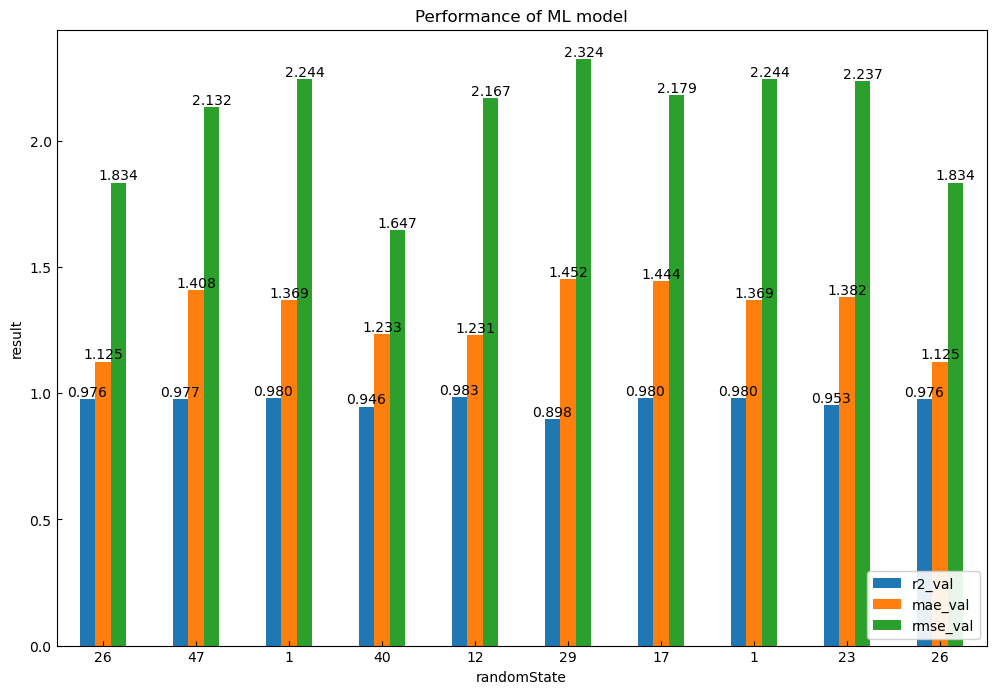

In [24]:
# 设置图片大小
# 创建绘图区域和轴对象
fig, ax = plt.subplots(figsize=(12, 8))

# 重复训练结果
# 在柱状图上标识数据
df_result.plot.bar(x='randomState', y=['r2_val', 'mae_val', 'rmse_val'], rot=0, ax=ax)
plt.title(f'Performance of ML model')
plt.ylabel('result')

# 在每个柱子上显示对应的数值
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f'{h:.3f}' for h in i.datavalues])

plt.legend(loc='lower right', framealpha=0.9)

# 显示图片
plt.show()
# plt.savefig('result/PIC/phonon_result_pred_metrics_pic/6-26(PearsonF-22)/phonon_pred_metrics.png',bbox_inches='tight')

In [25]:
avg_r2_val = df_result['r2_val'].mean()
avg_mae_val = df_result['mae_val'].mean()

print(f'Average validation r2: {avg_r2_val:0.4f}')
print(f'Average validation MAE: {avg_mae_val:0.4f}')

Average validation r2: 0.9649
Average validation MAE: 1.3137


# 预测predData

In [53]:
# load predDataSet
path = "pred_data/phonon1/pred_data(1).csv"  
df_pred = pd.read_csv(path)
df_pred.head()

number material_id formula  Wmax   density        Ef  Num_min  MenNum_min  \
0       1  mp-1183115  AcAlO3   NaN  8.728230 -3.690783        8          14   
1       2   mp-866101  AcCrO3   NaN  8.848788 -3.139736        8          14   
2       3   mp-861502  AcFeO3   NaN  8.889999 -2.772303        8          14   
3       4  mp-1183053  AcGaO3   NaN  9.314495 -3.064016        8          14   
4       5  mp-1178563  AgAsO3   NaN  6.425733 -1.274752        8          65   

   MenNum_max  Tm_min  ...  NfV_min  NV_min  NV_max  NsU_min  NdU_min  \
0          87    54.8  ...        0       3       6        0        0   
1          87    54.8  ...        0       3       6        0        0   
2          87    54.8  ...        0       3       8        0        0   
3          87    54.8  ...        0       3      13        0        0   
4          87    54.8  ...        0       6      15        0        0   

   NdU_max  NfU_min  NU_max  GSV_min  B_max  
0        9        0       9    9.105      3  
1        9        0       9    9.105      3  
2        9        0       9    9.105      3  
3        9        0       9    9.105      3  
4        0        0       3    9.105      3  

[5 rows x 26 columns]

In [54]:
# 预测集划分
feature = df_pred.iloc[:,4:]
target = df_pred["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature)

In [28]:
## 模型加载
model = ['xgboost', 'lgbm', 'rf', 'catboost', 'gbr']
columns=['xgboost_pred', 'lgbm_pred', 'rf_pred', 'catboost_pred', 'gbr_pred']
df_pred_result = pd.DataFrame()
j=0
for i in model:
    path_loadModel = 'model/phonon/6-26(Feature-22)/automl-'+i+'.pkl'
    store = path_loadModel
    with open(store, 'rb') as f:
        automl = pickle.load(f)
    phonon_pred = automl.predict(feature_std)
    df_pred_result.insert(j, columns[j], pd.DataFrame(phonon_pred))
    j+=1

In [33]:
df_pred_result.to_csv("pred_data/phonon1/pred_result(1).csv")

In [5]:
df_pred_result = pd.read_csv("pred_data/phonon1/pred_result(1).csv")
df_pred_result

formula  xgboost_pred  lgbm_pred    rf_pred  catboost_pred   gbr_pred
0    AcAlO3     39.604378  23.424928  24.849677      25.244339  25.315675
1    AcCrO3     40.652977  24.307227  25.296467      23.777997  22.715202
2    AcFeO3     39.383450  22.899126  23.622227      22.399309  19.827841
3    AcGaO3     38.124474  24.753193  24.863383      22.137999  24.344758
4    AgAsO3     37.778890  27.100648  22.712162      24.225356  27.293694
..      ...           ...        ...        ...            ...        ...
122   YbVO3     43.498370  25.906883  24.438326      23.375229  25.101577
123   YCrO3     40.910915  25.422303  25.449325      23.826764  23.904634
124   YRhO3     39.030840  23.258983  23.878812      23.212803  22.437045
125    YVO3     41.004044  23.610332  25.449325      23.095277  24.009500
126   ZnCO3     41.577457  45.315111  45.003278      37.850248  45.709741

[127 rows x 6 columns]

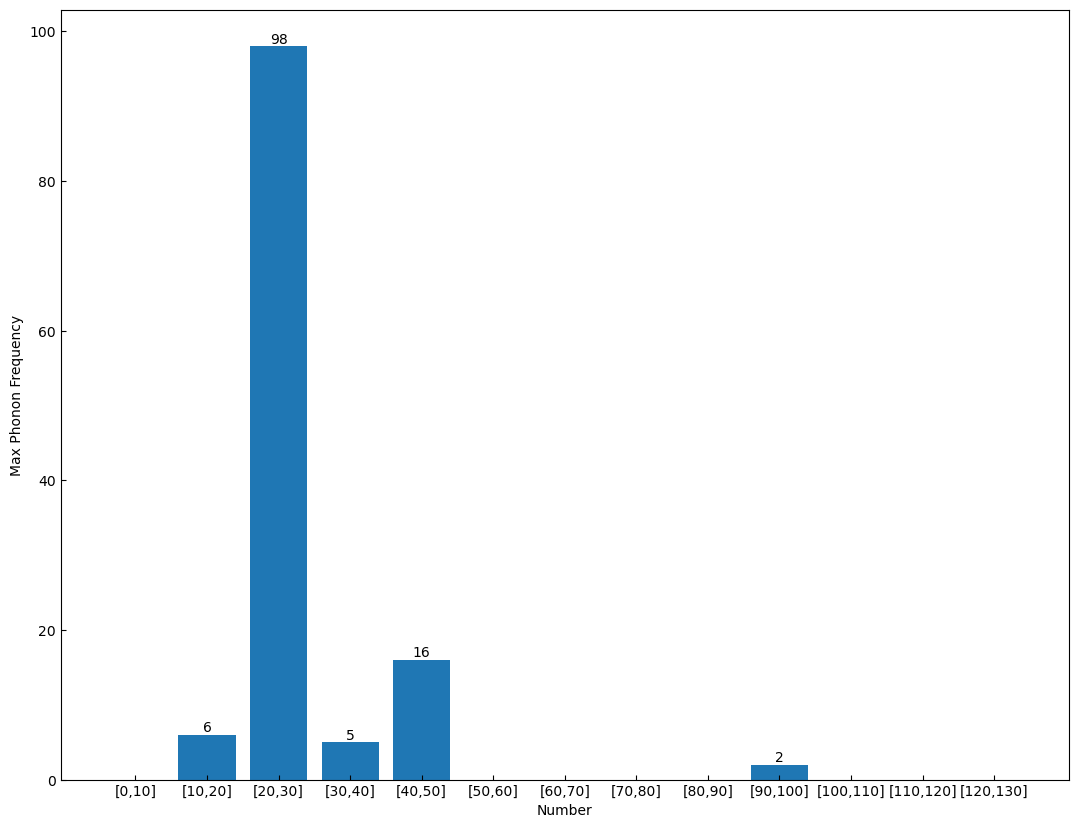

In [15]:
# 绘制 rf——model predict Wmax 分布情况

phononDict = countResult(df_pred_result,'rf_pred')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

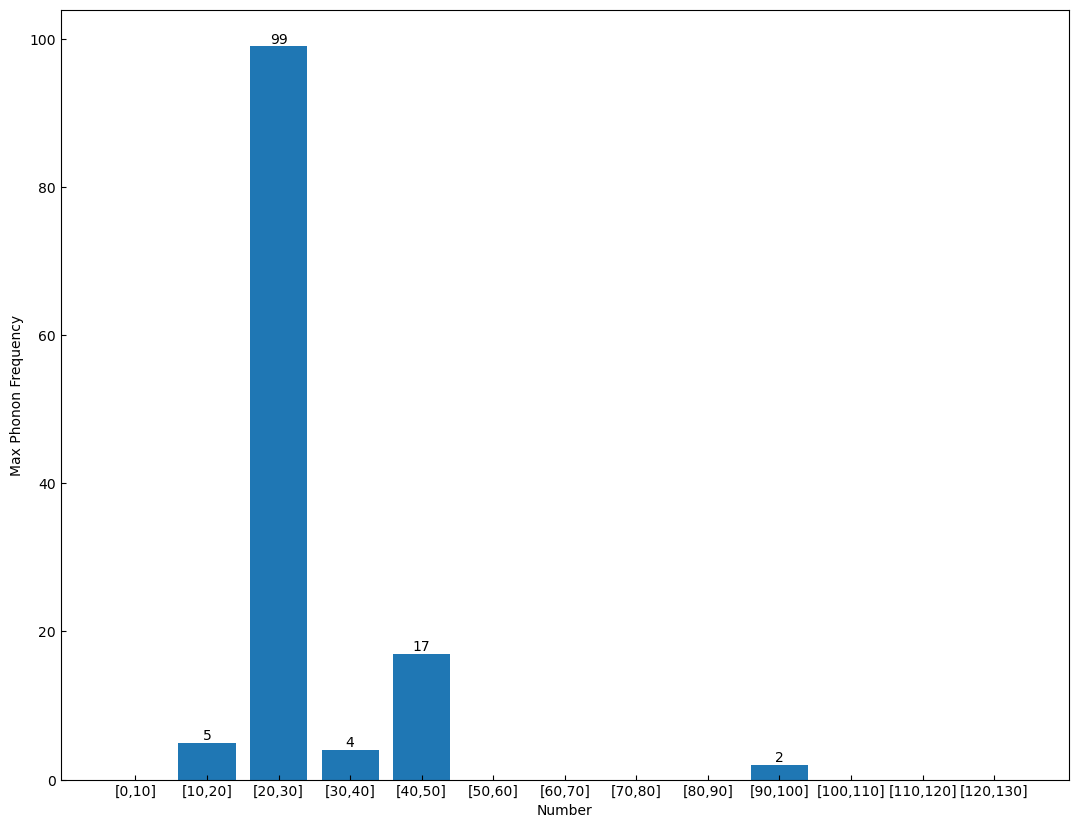

In [16]:
# 绘制 lgbm——model predict Wmax 分布情况

phononDict = countResult(df_pred_result,'lgbm_pred')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

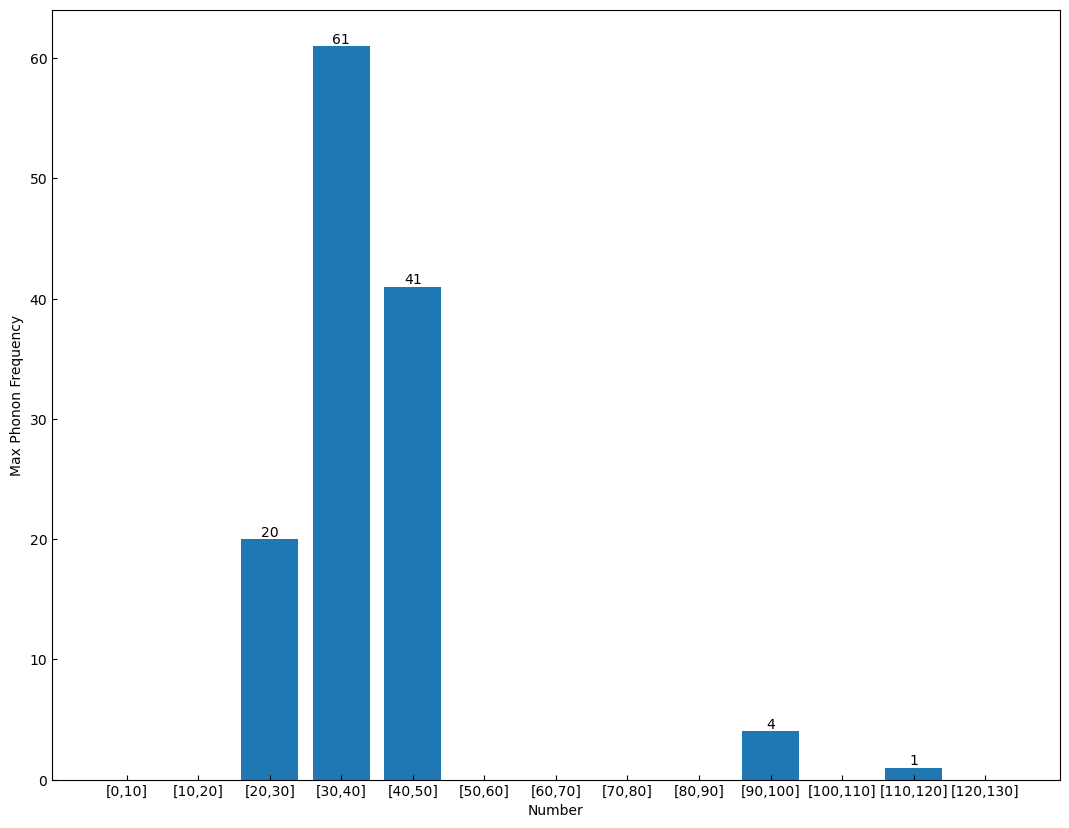

In [17]:
# 绘制 xgboost——model predict Wmax 分布情况

phononDict = countResult(df_pred_result,'xgboost_pred')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

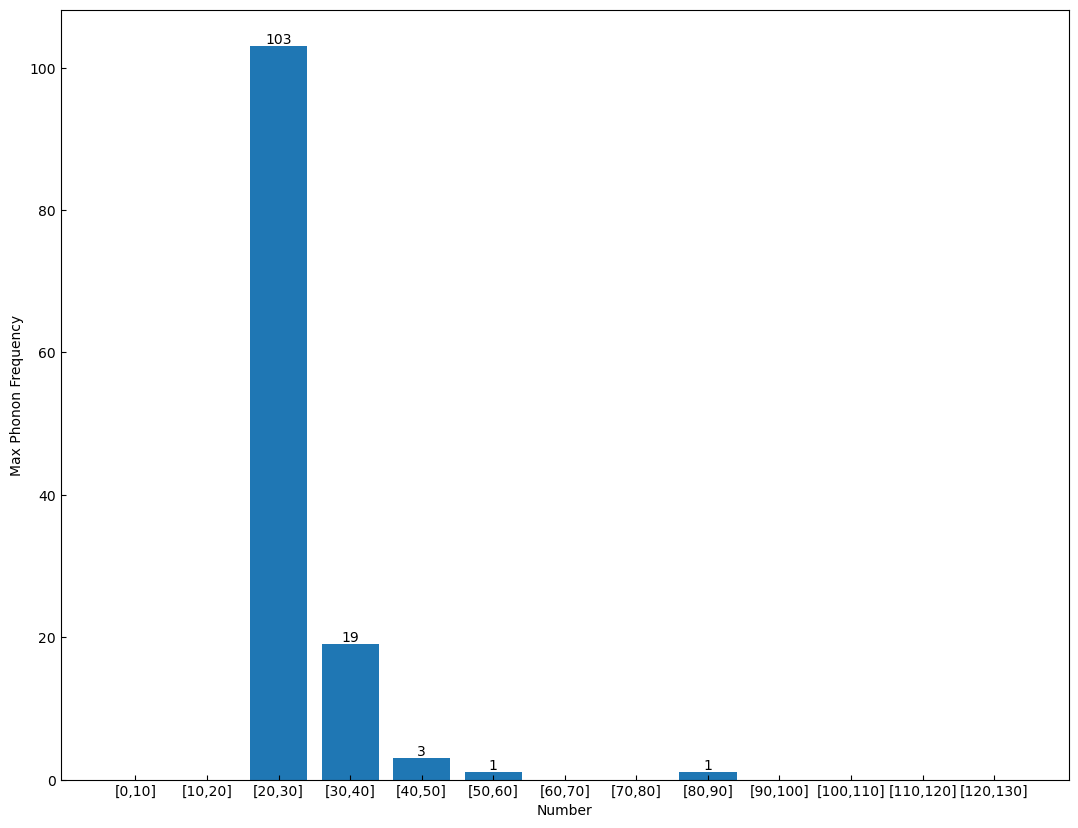

In [18]:
# 绘制 catboost——model predict Wmax 分布情况

phononDict = countResult(df_pred_result, 'catboost_pred')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

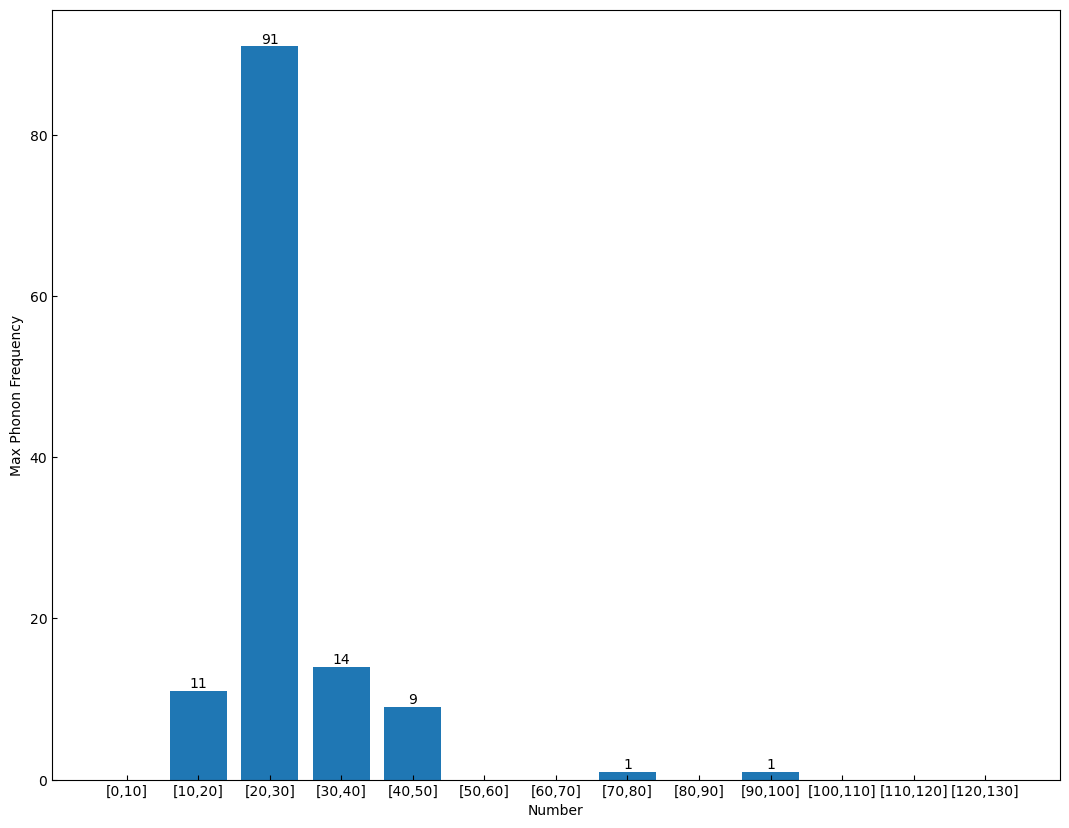

In [19]:
# 绘制 catboost——model predict Wmax 分布情况

phononDict = countResult(df_pred_result, 'gbr_pred')
# 获取字典的键和值
brands = list(phononDict.keys())
counts = list(phononDict.values())

# 创建指定大小的图像
plt.figure(figsize=(13, 10))

# 创建柱状图
plt.bar(brands, counts)
plt.rcParams['xtick.direction'] = 'in'#将x周的刻度线方向设置向内
plt.rcParams['ytick.direction'] = 'in'#将y轴的刻度方向设置向内


# 在每个柱子上显示数字
for i in range(len(brands)):
    if counts[i] != 0:
        plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')

# 添加标题和标签
plt.title('')
plt.xlabel('Number')
plt.ylabel('Max Phonon Frequency')

# 显示图形
plt.show()

# Shap分析

In [6]:
# 导包
import shap
import lightgbm as lgb

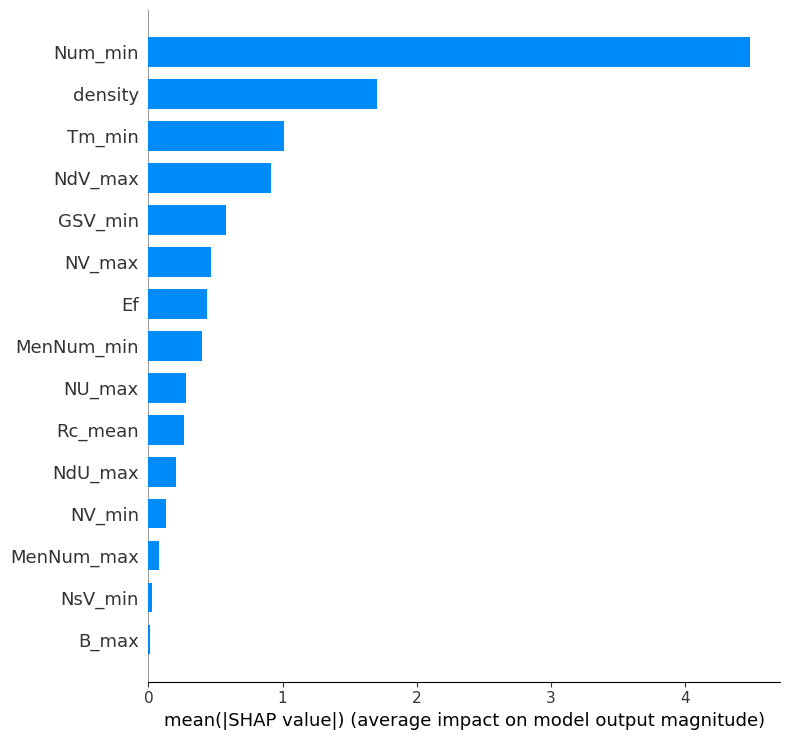

In [13]:
params = {'n_estimators': 27,
          'num_leaves': 70,
          'min_child_samples': 2,
          'learning_rate': 0.15056166681183433,
          # 'log_max_bin': 10,
          'colsample_bytree': 0.6816088762511493,
          'reg_alpha': 0.0020145913289276885,
          'reg_lambda': 0.036371692462722476
         }

# 初始化LightGBM回归模型
model_lgb_shap = lgb.LGBMRegressor(**params)
model_lgb_shap.fit(x_train, y_train)

# 计算 shap值
shap_values = shap.Explainer(model_lgb_shap).shap_values(x_test)
# 绘制SHAP 得到的特征重要性排名
shap.summary_plot(shap_values, x_test, plot_type="bar", show=False)

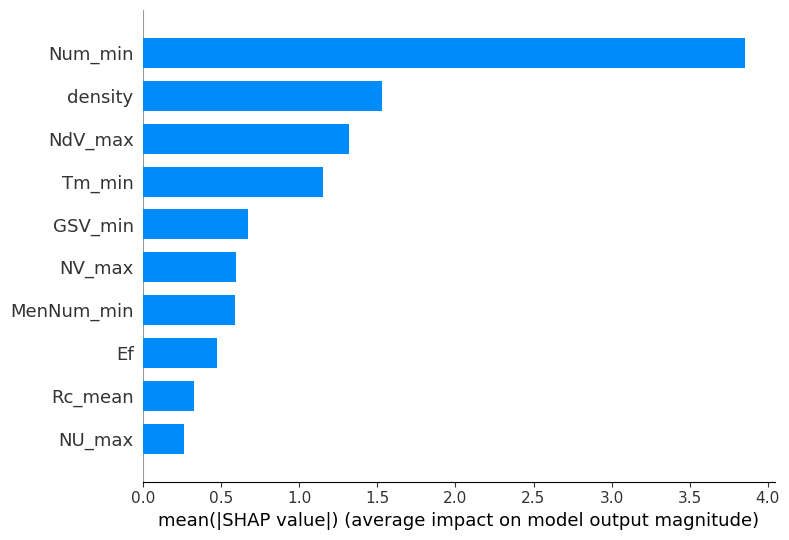

In [85]:
# 特征筛选完后的dataset
df_train_selected = pd.read_csv("train_data/phonon1/trainData(3-f22).csv")
# df_train_selected = pd.read_csv("train_data/phonon1/trainData(4-f15).csv")
feature = df_train_selected.iloc[:,4:]
target = df_train_selected["Wmax"]

# 标准化处理
feature_std = dataStandardScaler(feature)

x_train_SHAP, x_test_SHAP, y_train_SHAP, y_test_SHAP = train_test_split(feature_std,
                                                                        target,
                                                                        test_size=0.2,
                                                                        random_state=79)

# x_train_SHAP = feature_std
# y_train_SHAP = target


# load model
# 定义LightGBM模型的参数
# 精度更高
# params = {'n_estimators': 56,
#           'num_leaves': 59,
#           'min_child_samples': 3,
#           'learning_rate': 0.20965284786018218,
#           'log_max_bin': 7,
#           'colsample_bytree': 0.5614656111885798,
#           'reg_alpha': 0.0009765625,
#           'reg_lambda': 0.022677313474640613}
# 精度较低
params = {'n_estimators': 63,
          'num_leaves': 25,
          'min_child_samples': 2,
          'learning_rate': 0.22847858708467067,
          # 'log_max_bin': 9,
          'colsample_bytree': 0.6129590698239831,
          'reg_alpha': 0.0009765625,
          'reg_lambda': 0.0009765625}

# 初始化LightGBM回归模型
model_lgb_shap = lgb.LGBMRegressor(**params)
model_lgb_shap.fit(x_train_SHAP, y_train_SHAP)

# 训练结束使用预测集进行评估
# y_pred = model_lgb_shap(x_test_SHAP)
# pred_result = regression_metrics(y_test, y_pred)

# 计算 shap值
shap_values = shap.Explainer(model_lgb_shap, algorithm="tree").shap_values(feature_std)

# 绘制SHAP 得到的特征重要性排名
shap.summary_plot(shap_values, feature_std, plot_type="bar", show=False, max_display=10)

In [81]:
shap_values

array([[ 1.46568559e+00,  7.34797682e-01, -2.56929611e+00, ...,
        -9.02802580e-02, -3.38302328e-01, -2.42608569e-02],
       [-6.58081904e-01, -5.24413845e-01, -2.58479308e+00, ...,
        -5.10408029e-02, -4.49425603e-01, -2.82476968e-02],
       [ 1.82065964e+00,  1.29673185e+00,  9.33383575e+00, ...,
         2.96078197e-01, -3.30059156e-01, -1.46082221e-02],
       ...,
       [-1.33737455e+00, -2.61375668e-02, -2.56228441e+00, ...,
        -7.82646956e-03, -3.77815644e-01, -3.00085560e-02],
       [-1.38526054e+00, -2.94964972e-02, -2.56228441e+00, ...,
        -2.38069584e-02, -3.77815644e-01, -3.00085560e-02],
       [-1.28839492e+00, -3.13525707e-02, -2.56222903e+00, ...,
        -7.47603971e-03, -3.77815644e-01, -3.00085560e-02]])

In [77]:
shap.initjs()
shap.force_plot(shap.Explainer(model_lgb_shap, algorithm="tree").expected_value, shap_values, feature_std)

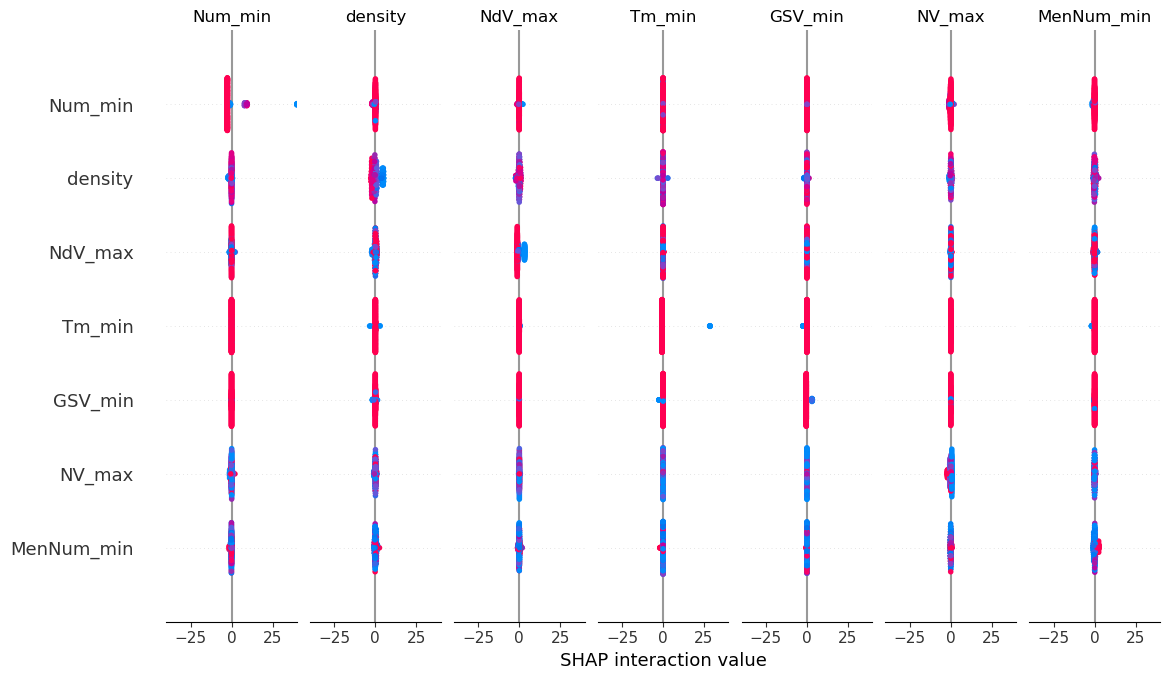

In [78]:
shap_interaction_values =shap.Explainer(model_lgb_shap, algorithm="tree").shap_interaction_values(feature_std)
shap.summary_plot(shap_interaction_values, feature_std)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


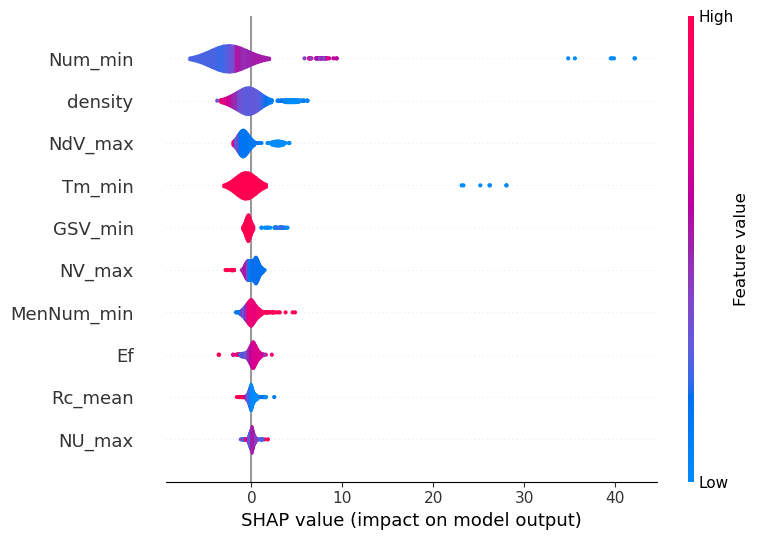

In [94]:
# 显示预测因子与目标变量之间的正负关系
shap.summary_plot(shap_values, feature_std, max_display=10, plot_type="violin")

# shap.summary_plot(shap_values, x_test_SHAP, xlim=(0, 0.5))

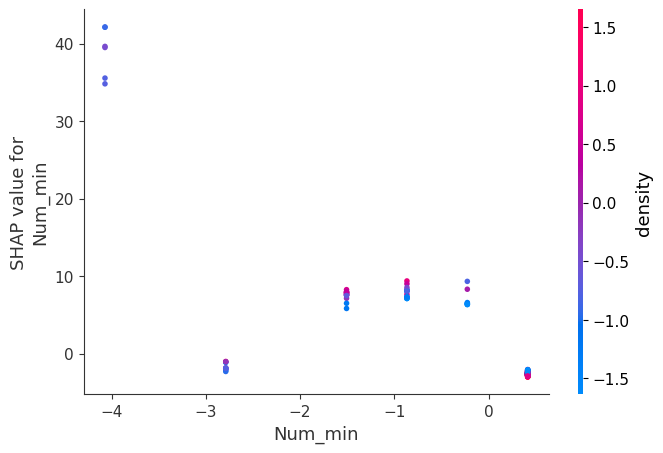

In [65]:
shap.dependence_plot("Num_min", shap_values, x_train_SHAP)